In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import networkx as nx

### Initial Analysis

In [3]:
data = pd.read_csv("./data/PiNUI-human.csv")
data.head()

,seqA,seqB,interaction
0,MKRRASDRGAGETSARAKALGSGISGNNAKRAGPFILGPRLGNSPV...,MAASAARGAAALRRSINQPVAFVRRIPWTAASSQLKEHFAQFGHVR...,1
1,MEAPSGSEPGGDGAGDCAHPDPRAPGAAAPSSGPGPCAAARESERQ...,MKLFHTADWHLGKLVHGVYMTEDQKIVLDQFVQAVEEEKPDAVIIA...,1
2,MDQNSVPEKAQNEADTNNADRFFRSHSSPPHHRPGHSRALHHYELH...,MTHCCSPCCQPTCCRTTCWQPTTVTTCSSTPCCQPSCCVSSCCQPC...,1
3,MFADLDYDIEEDKLGIPTVPGKVTLQKDAQNLIGISIGGGAQYCPC...,MARTLRPSPLCPGGGKAQLSSASLLGAGLLLQPPTPPPLLLLLFPL...,1
4,MAEGNHRKKPLKVLESLGKDFLTGVLDNLVEQNVLNWKEEEKKKYY...,MASADSRRVADGGGAGGTFQPYLDTLRQELQQTDPTLLSVVVAVLA...,1


In [4]:
# Get the sequences
all_proteins = list(set(data['seqA']).union(set(data['seqB'])))
N = len(all_proteins)
N

30263

## Visualization

### 1. Visualizing basic distributions

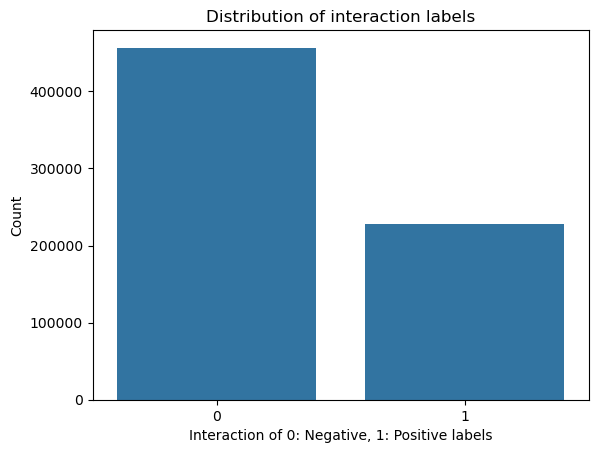

In [5]:
# Count plot for interaction labels
sns.countplot(x='interaction', data=data)
plt.title("Distribution of interaction labels")
plt.xlabel("Interaction of 0: Negative, 1: Positive labels")
plt.ylabel("Count")
plt.show()

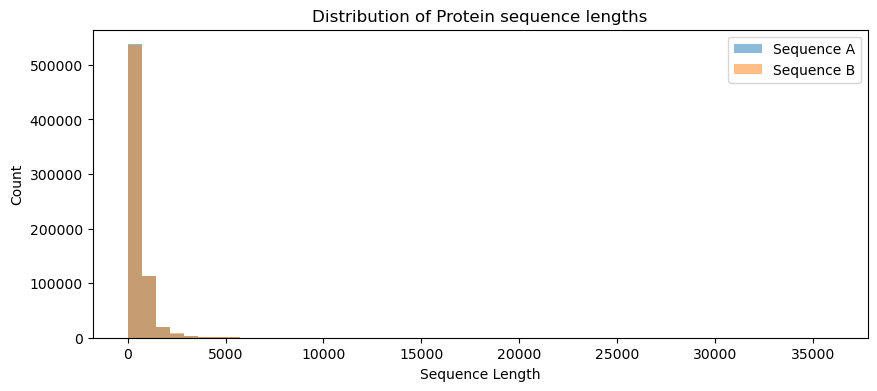

In [6]:
# Sequence length distribution
# Histogram of lenghts of proteins in Sequence-A and Sequence-B

data['seqA_length'] = data['seqA'].apply(len)
data['seqB_length'] = data['seqB'].apply(len)

plt.figure(figsize=(10, 4))
plt.hist(data['seqA_length'], bins=50, alpha=0.5, label='Sequence A')
plt.hist(data['seqB_length'], bins=50, alpha=0.5, label='Sequence B')
plt.title("Distribution of Protein sequence lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.legend()
plt.show()

### 2. Visualize the Embedding Space

In [7]:
TARGET_TOTAL_SAMPLES = 1000
RANDOM_SEED = 42 

data_full = data
print(f"Loaded full dataset with {len(data_full)} rows.")

data_full['interaction'] = data_full['interaction'].astype(int)

data_pos = data_full[data_full['interaction'] == 1]
data_neg = data_full[data_full['interaction'] == 0]
n_pos_available = len(data_pos)
n_neg_available = len(data_neg)
print(f"Available positive samples (interaction=1): {n_pos_available}")
print(f"Available negative samples (interaction=0): {n_neg_available}")

# sample size per class for balancing
target_samples_per_class = TARGET_TOTAL_SAMPLES // 2

# Adjust sample size based on availability
n_samples_per_class = min(n_pos_available, n_neg_available, target_samples_per_class)

print(f"Sampling {n_samples_per_class} from each class.")
final_total_samples = n_samples_per_class * 2
print(f"Total samples in the final balanced dataset will be: {final_total_samples}")

# Perform sampling
data_pos_sampled = data_pos.sample(n=n_samples_per_class, random_state=RANDOM_SEED)
data_neg_sampled = data_neg.sample(n=n_samples_per_class, random_state=RANDOM_SEED)

# Combine the sampled data
data_model = pd.concat([data_pos_sampled, data_neg_sampled])

# Shuffle the combined DataFrame
print("Shuffling the combined dataset...")
data_model = data_model.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
print(f"Using {len(data_model)} rows.")

Loaded full dataset with 684951 rows.
Available positive samples (interaction=1): 228317
Available negative samples (interaction=0): 456634
Sampling 500 from each class.
Total samples in the final balanced dataset will be: 1000
Shuffling the combined dataset...
Using 1000 rows.


In [8]:
# Getting the embeddings
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model.eval()

embeddings_list = []
labels = []

device = "cuda" if torch.cuda.is_available() else "cpu"
esm_model.to(device)

N_samples = 1000
for idx, row in data_model.head(N_samples).iterrows():
    # Concatenate the sequences with a delimiter
    pair_input = row['seqA'] + " [SEP] " + row['seqB']
    
    # Tokenize the pair to consistent max_length
    tokens = tokenizer(pair_input, return_tensors="pt", truncation=True, padding='max_length', max_length=1022)
    
    with torch.no_grad():
        outputs = esm_model(**tokens)
    
    # Pool the embeddings using mean pooling across tokens
    # outputs.last_hidden_state has shape (1, sequence_length, hidden_size)
    pooled_embedding = outputs.last_hidden_state.mean(dim=1)  # shape becomes (1, hidden_size)
    
    # Convert to numpy and store
    embeddings_list.append(pooled_embedding.squeeze(0).cpu().numpy())
    labels.append(row['interaction'])

embeddings_array = np.vstack(embeddings_list)
print(f"Shape of embeddigns: {embeddings_array.shape}")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Shape of embeddigns: (1000, 320)


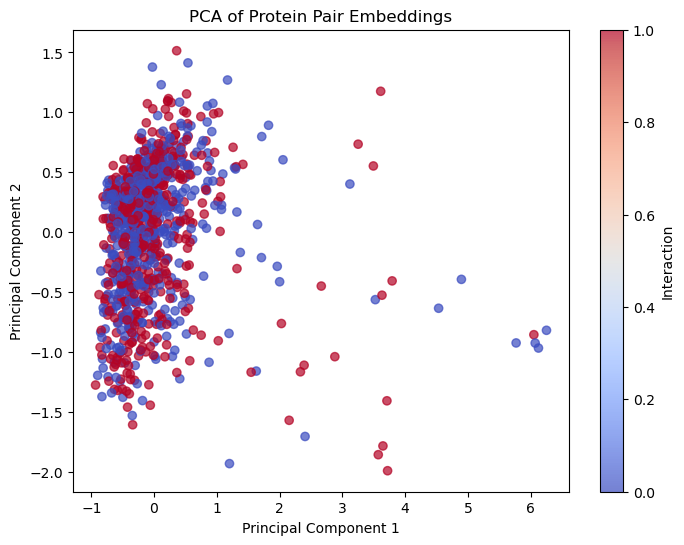

In [9]:
# Dimentionality reduction - PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=labels, cmap="coolwarm", alpha=0.7)
plt.title("PCA of Protein Pair Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Interaction")
plt.show()

t-SNE shape: (1000, 2)


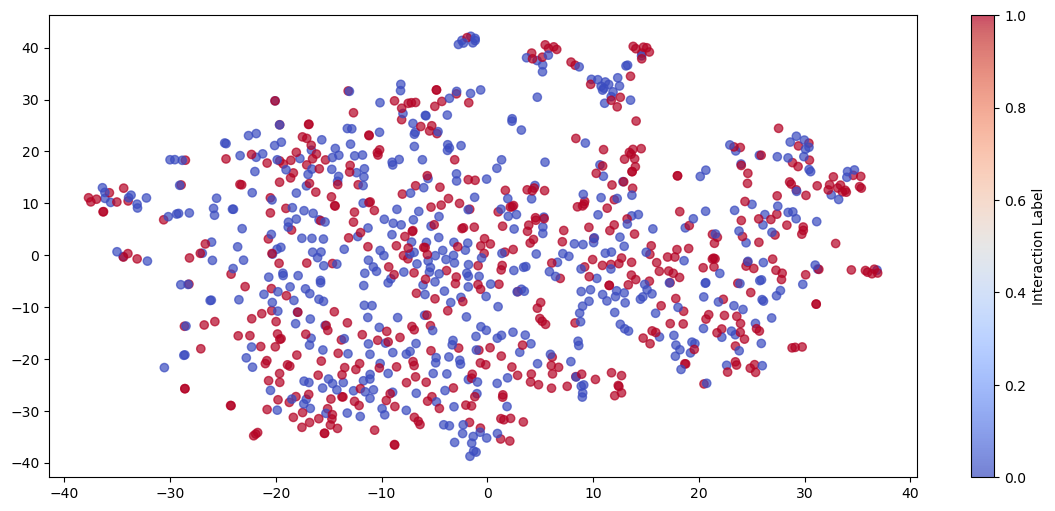

In [10]:
# Dimentionality reduction - tSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings_array)
print("t-SNE shape:", embeddings_tsne.shape)

plt.figure(figsize=(14, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Interaction Label")
plt.show()

/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP shape: (1000, 2)


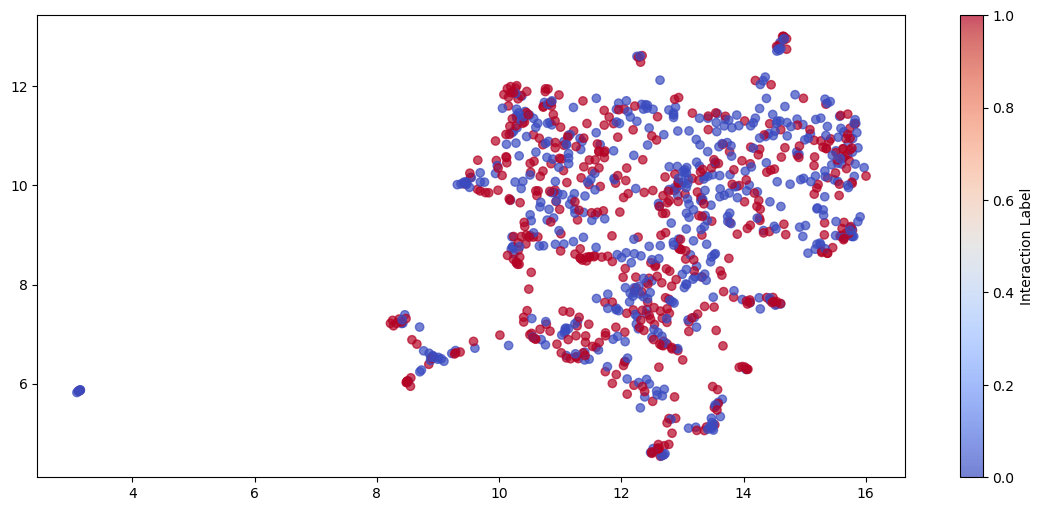

In [11]:
# Dimentionality reduction - UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings_array)
print("UMAP shape:", embeddings_umap.shape)

plt.figure(figsize=(14, 6))
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Interaction Label")
plt.show()

### 3. Network Visualization

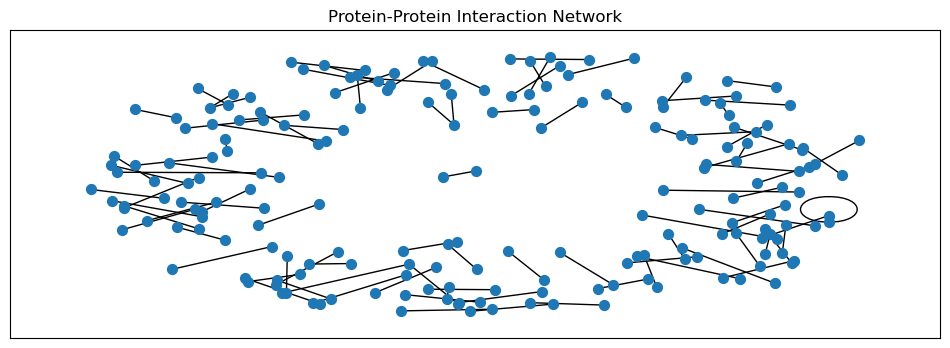

In [12]:
G = nx.from_pandas_edgelist(data[100:200], source='seqA', target='seqB', edge_attr=True)

plt.figure(figsize=(12,4))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw_networkx(G, pos, node_size=50, font_size=8, with_labels=False)
plt.title("Protein-Protein Interaction Network")
plt.show()

## Implementation

### MLP

In [13]:
# Dataset Class
class PinuiDataset(Dataset):
    def __init__(self, data, esm_model, tokenizer, device='cpu', batch_size=32, max_length=1022):
        self.seqA = list(data['seqA'])
        self.seqB = list(data['seqB'])
        self.interactions = list(data['interaction'])
        self.embeddings = []
        self.labels = []
        self.device = device

        esm_model.to(device)
        esm_model.eval()

        print("Generating embeddings in batches...")
        num_pairs = len(self.seqA)
        with torch.no_grad():
            for i in tqdm(range(0, num_pairs, batch_size)):
                batch_seqA = self.seqA[i:min(i + batch_size, num_pairs)]
                batch_seqB = self.seqB[i:min(i + batch_size, num_pairs)]
                batch_interactions = self.interactions[i:min(i + batch_size, num_pairs)]

                pair_inputs = [s1 + " [SEP] " + s2 for s1, s2 in zip(batch_seqA, batch_seqB)]
                tokens = tokenizer(pair_inputs, return_tensors="pt", truncation=True, padding='max_length', max_length=max_length)
                tokens = {k: v.to(device) for k, v in tokens.items()}

                outputs = esm_model(**tokens)
                batch_embeddings = outputs.last_hidden_state.mean(dim=1)

                self.embeddings.extend(batch_embeddings.cpu())
                self.labels.extend([torch.tensor(interaction, dtype=torch.float) for interaction in batch_interactions])

        print("Embeddings generated.")
        self.embeddings = torch.stack(self.embeddings)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [14]:
# Generalized MLP Class
class MLP(nn.Module):
    def __init__(self, layer_sizes, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Apply ReLU and dropout except after the last layer
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [15]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    model.to(device)
    metrics = {
        "train_losses": [], "eval_losses": [],
        "train_accuracies": [], "eval_accuracies": [],
        "train_precisions": [], "eval_precisions": [],
        "train_recalls": [], "eval_recalls": [],
        "train_f1s": [], "eval_f1s": [],
        "eval_auc": []
    }

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_targets, all_train_probs = [], [], []

        for embeddings, targets in train_loader:
            embeddings, targets = embeddings.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * embeddings.size(0)
            probs = torch.sigmoid(outputs.squeeze())
            preds = (probs > 0.5).long()
            all_train_preds.extend(preds.cpu().detach().numpy())
            all_train_targets.extend(targets.cpu().detach().numpy())  # Targets may not require grad, but this is safe
            all_train_probs.extend(probs.cpu().detach().numpy())

        metrics["train_losses"].append(running_loss / len(train_loader.dataset))
        metrics["train_accuracies"].append(accuracy_score(all_train_targets, all_train_preds))
        metrics["train_precisions"].append(precision_score(all_train_targets, all_train_preds, zero_division=0))
        metrics["train_recalls"].append(recall_score(all_train_targets, all_train_preds, zero_division=0))
        metrics["train_f1s"].append(f1_score(all_train_targets, all_train_preds, zero_division=0))

        model.eval()
        running_eval_loss = 0.0
        all_eval_preds, all_eval_targets, all_eval_probs = [], [], []

        with torch.no_grad():
            for embeddings, targets in val_loader:
                embeddings, targets = embeddings.to(device), targets.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs.squeeze(), targets)
                running_eval_loss += loss.item() * embeddings.size(0)
                probs = torch.sigmoid(outputs.squeeze())
                preds = (probs > 0.5).long()
                all_eval_preds.extend(preds.cpu().detach().numpy())
                all_eval_targets.extend(targets.cpu().detach().numpy())
                all_eval_probs.extend(probs.cpu().detach().numpy())

        metrics["eval_losses"].append(running_eval_loss / len(val_loader.dataset))
        metrics["eval_accuracies"].append(accuracy_score(all_eval_targets, all_eval_preds))
        metrics["eval_precisions"].append(precision_score(all_eval_targets, all_eval_preds, zero_division=0))
        metrics["eval_recalls"].append(recall_score(all_eval_targets, all_eval_preds, zero_division=0))
        metrics["eval_f1s"].append(f1_score(all_eval_targets, all_eval_preds, zero_division=0))
        metrics["eval_auc"].append(roc_auc_score(all_eval_targets, all_eval_probs))

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train - Loss: {metrics['train_losses'][-1]:.4f} | Acc: {metrics['train_accuracies'][-1]:.4f} | Prec: {metrics['train_precisions'][-1]:.4f} | Rec: {metrics['train_recalls'][-1]:.4f} | F1: {metrics['train_f1s'][-1]:.4f}")
        print(f"  Eval  - Loss: {metrics['eval_losses'][-1]:.4f} | Acc: {metrics['eval_accuracies'][-1]:.4f} | Prec: {metrics['eval_precisions'][-1]:.4f} | Rec: {metrics['eval_recalls'][-1]:.4f} | F1: {metrics['eval_f1s'][-1]:.4f} | AUC: {metrics['eval_auc'][-1]:.4f}")

    return metrics

In [ ]:
# Load Data and Model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
input_dim = esm_model.config.hidden_size
print(f"ESM hidden size: {input_dim}")

TARGET_TOTAL_SAMPLES = 50000
RANDOM_SEED = 42

data_full = data
print(f"Loaded full dataset with {len(data_full)} rows.")

data_full['interaction'] = data_full['interaction'].astype(int)

data_pos = data_full[data_full['interaction'] == 1]
data_neg = data_full[data_full['interaction'] == 0]
n_pos_available = len(data_pos)
n_neg_available = len(data_neg)
print(f"Available positive samples (interaction=1): {n_pos_available}")
print(f"Available negative samples (interaction=0): {n_neg_available}")

# sample size per class for balancing
target_samples_per_class = TARGET_TOTAL_SAMPLES // 2

# Adjust sample size based on availability
n_samples_per_class = min(n_pos_available, n_neg_available, target_samples_per_class)

print(f"Sampling {n_samples_per_class} from each class.")
final_total_samples = n_samples_per_class * 2
print(f"Total samples in the final balanced dataset will be: {final_total_samples}")

# Perform sampling
data_pos_sampled = data_pos.sample(n=n_samples_per_class, random_state=RANDOM_SEED)
data_neg_sampled = data_neg.sample(n=n_samples_per_class, random_state=RANDOM_SEED)

# Combine the sampled data
data_model = pd.concat([data_pos_sampled, data_neg_sampled])

# Shuffle the combined DataFrame
print("Shuffling the combined dataset...")
data_model = data_model.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
print(f"Using {len(data_model)} rows.")

device = "cuda" if torch.cuda.is_available() else "cpu"
data_set = PinuiDataset(data_model, esm_model=esm_model, tokenizer=tokenizer, device=device, batch_size=64, max_length=1022)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM hidden size: 320
Loaded full dataset with 684951 rows.
Available positive samples (interaction=1): 228317
Available negative samples (interaction=0): 456634
Sampling 25000 from each class.
Total samples in the final balanced dataset will be: 50000
Shuffling the combined dataset...
Using 50000 rows.
Generating embeddings in batches...


  0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
# Define MLP Configurations for Ablation Study
configurations = [
    {"name": "Baseline", "layers": [input_dim, 1024, 256, 1], "dropout": 0.2, "lr": 1e-4, "batch_size": 32},
    {"name": "No Dropout", "layers": [input_dim, 1024, 256, 1], "dropout": 0.0, "lr": 1e-4, "batch_size": 32},
    {"name": "Higher Dropout", "layers": [input_dim, 1024, 256, 1], "dropout": 0.5, "lr": 1e-4, "batch_size": 32},
    {"name": "Simpler MLP", "layers": [input_dim, 512, 1], "dropout": 0.2, "lr": 1e-4, "batch_size": 32},
    {"name": "More Complex MLP", "layers": [input_dim, 1024, 512, 256, 1], "dropout": 0.2, "lr": 1e-4, "batch_size": 32},
]

# K-Fold Cross-Validation for MLP
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
labels = data_set.labels.numpy()
epochs = 10
all_config_metrics = {}

for config in configurations:
    print(f"\nEvaluating configuration: {config['name']}")
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"  Fold {fold+1}/{k}")
        train_subset = Subset(data_set, train_idx)
        val_subset = Subset(data_set, val_idx)

        train_loader = DataLoader(train_subset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
        val_loader = DataLoader(val_subset, batch_size=config['batch_size'], shuffle=False, num_workers=0)

        model = MLP(config['layers'], config['dropout'])
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
        criterion = nn.BCEWithLogitsLoss()

        metrics = train(model, train_loader, val_loader, optimizer, criterion, epochs, device)
        fold_metrics.append(metrics)

    # Average metrics across folds
    all_config_metrics[config['name']] = {
        key: np.mean([m[key] for m in fold_metrics], axis=0).tolist()
        for key in fold_metrics[0].keys()
    }


Evaluating configuration: Baseline
  Fold 1/5


 40%|████      | 4/10 [00:00<00:00, 15.78it/s]

Epoch 1/10
  Train - Loss: 0.6944 | Acc: 0.4825 | Prec: 0.4748 | Rec: 0.3300 | F1: 0.3894
  Eval  - Loss: 0.6923 | Acc: 0.5500 | Prec: 0.6923 | Rec: 0.1800 | F1: 0.2857 | AUC: 0.5300
Epoch 2/10
  Train - Loss: 0.6908 | Acc: 0.5650 | Prec: 0.6083 | Rec: 0.3650 | F1: 0.4562
  Eval  - Loss: 0.6918 | Acc: 0.4800 | Prec: 0.4643 | Rec: 0.2600 | F1: 0.3333 | AUC: 0.5208
Epoch 3/10
  Train - Loss: 0.6885 | Acc: 0.5975 | Prec: 0.6054 | Rec: 0.5600 | F1: 0.5818
  Eval  - Loss: 0.6908 | Acc: 0.4800 | Prec: 0.4773 | Rec: 0.4200 | F1: 0.4468 | AUC: 0.5296
Epoch 4/10
  Train - Loss: 0.6862 | Acc: 0.6425 | Prec: 0.6432 | Rec: 0.6400 | F1: 0.6416
  Eval  - Loss: 0.6898 | Acc: 0.4500 | Prec: 0.4528 | Rec: 0.4800 | F1: 0.4660 | AUC: 0.5360
Epoch 5/10
  Train - Loss: 0.6835 | Acc: 0.6175 | Prec: 0.5907 | Rec: 0.7650 | F1: 0.6667
  Eval  - Loss: 0.6889 | Acc: 0.4900 | Prec: 0.4923 | Rec: 0.6400 | F1: 0.5565 | AUC: 0.5404
Epoch 6/10
  Train - Loss: 0.6820 | Acc: 0.6050 | Prec: 0.5946 | Rec: 0.6600 | F1: 0.

100%|██████████| 10/10 [00:00<00:00, 19.76it/s]


Epoch 7/10
  Train - Loss: 0.6764 | Acc: 0.6075 | Prec: 0.6150 | Rec: 0.5750 | F1: 0.5943
  Eval  - Loss: 0.6870 | Acc: 0.5200 | Prec: 0.5263 | Rec: 0.4000 | F1: 0.4545 | AUC: 0.5360
Epoch 8/10
  Train - Loss: 0.6742 | Acc: 0.5925 | Prec: 0.6082 | Rec: 0.5200 | F1: 0.5606
  Eval  - Loss: 0.6860 | Acc: 0.4900 | Prec: 0.4884 | Rec: 0.4200 | F1: 0.4516 | AUC: 0.5368
Epoch 9/10
  Train - Loss: 0.6708 | Acc: 0.6100 | Prec: 0.6058 | Rec: 0.6300 | F1: 0.6176
  Eval  - Loss: 0.6854 | Acc: 0.4900 | Prec: 0.4889 | Rec: 0.4400 | F1: 0.4632 | AUC: 0.5348
Epoch 10/10
  Train - Loss: 0.6649 | Acc: 0.6350 | Prec: 0.6274 | Rec: 0.6650 | F1: 0.6456
  Eval  - Loss: 0.6849 | Acc: 0.4800 | Prec: 0.4800 | Rec: 0.4800 | F1: 0.4800 | AUC: 0.5348
  Fold 2/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6932 | Acc: 0.5150 | Prec: 0.5093 | Rec: 0.8250 | F1: 0.6298
  Eval  - Loss: 0.6919 | Acc: 0.5000 | Prec: 0.5000 | Rec: 0.9800 | F1: 0.6622 | AUC: 0.6048
Epoch 2/10
  Train - Loss: 0.6925 | Acc: 0.4975 | Prec: 0.4966 | Rec: 0.3650 | F1: 0.4207
  Eval  - Loss: 0.6904 | Acc: 0.5700 | Prec: 0.7059 | Rec: 0.2400 | F1: 0.3582 | AUC: 0.6160


 60%|██████    | 6/10 [00:00<00:00, 27.26it/s]

Epoch 3/10
  Train - Loss: 0.6892 | Acc: 0.5750 | Prec: 0.5974 | Rec: 0.4600 | F1: 0.5198
  Eval  - Loss: 0.6888 | Acc: 0.6000 | Prec: 0.5962 | Rec: 0.6200 | F1: 0.6078 | AUC: 0.6176
Epoch 4/10
  Train - Loss: 0.6875 | Acc: 0.5900 | Prec: 0.5756 | Rec: 0.6850 | F1: 0.6256
  Eval  - Loss: 0.6874 | Acc: 0.6100 | Prec: 0.6000 | Rec: 0.6600 | F1: 0.6286 | AUC: 0.6148
Epoch 5/10
  Train - Loss: 0.6858 | Acc: 0.6000 | Prec: 0.5763 | Rec: 0.7550 | F1: 0.6537
  Eval  - Loss: 0.6857 | Acc: 0.5600 | Prec: 0.5417 | Rec: 0.7800 | F1: 0.6393 | AUC: 0.6252
Epoch 6/10
  Train - Loss: 0.6830 | Acc: 0.6000 | Prec: 0.5730 | Rec: 0.7850 | F1: 0.6624
  Eval  - Loss: 0.6829 | Acc: 0.6300 | Prec: 0.6102 | Rec: 0.7200 | F1: 0.6606 | AUC: 0.6240
Epoch 7/10
  Train - Loss: 0.6821 | Acc: 0.5800 | Prec: 0.6039 | Rec: 0.4650 | F1: 0.5254
  Eval  - Loss: 0.6804 | Acc: 0.5700 | Prec: 0.6000 | Rec: 0.4200 | F1: 0.4941 | AUC: 0.6232
Epoch 8/10
  Train - Loss: 0.6764 | Acc: 0.5750 | Prec: 0.5949 | Rec: 0.4700 | F1: 0.

100%|██████████| 10/10 [00:00<00:00, 26.65it/s]


Epoch 9/10
  Train - Loss: 0.6730 | Acc: 0.6125 | Prec: 0.5974 | Rec: 0.6900 | F1: 0.6404
  Eval  - Loss: 0.6749 | Acc: 0.6200 | Prec: 0.5968 | Rec: 0.7400 | F1: 0.6607 | AUC: 0.6264
Epoch 10/10
  Train - Loss: 0.6685 | Acc: 0.5925 | Prec: 0.5949 | Rec: 0.5800 | F1: 0.5873
  Eval  - Loss: 0.6719 | Acc: 0.6100 | Prec: 0.6078 | Rec: 0.6200 | F1: 0.6139 | AUC: 0.6252
  Fold 3/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6937 | Acc: 0.5175 | Prec: 0.6522 | Rec: 0.0750 | F1: 0.1345
  Eval  - Loss: 0.6917 | Acc: 0.5700 | Prec: 0.6842 | Rec: 0.2600 | F1: 0.3768 | AUC: 0.6304
Epoch 2/10
  Train - Loss: 0.6913 | Acc: 0.5450 | Prec: 0.5344 | Rec: 0.7000 | F1: 0.6061
  Eval  - Loss: 0.6906 | Acc: 0.5700 | Prec: 0.5467 | Rec: 0.8200 | F1: 0.6560 | AUC: 0.6156


 30%|███       | 3/10 [00:00<00:00, 26.02it/s]

Epoch 3/10
  Train - Loss: 0.6887 | Acc: 0.5875 | Prec: 0.5581 | Rec: 0.8400 | F1: 0.6707
  Eval  - Loss: 0.6895 | Acc: 0.5900 | Prec: 0.5634 | Rec: 0.8000 | F1: 0.6612 | AUC: 0.6116
Epoch 4/10
  Train - Loss: 0.6868 | Acc: 0.5675 | Prec: 0.5437 | Rec: 0.8400 | F1: 0.6601
  Eval  - Loss: 0.6885 | Acc: 0.5800 | Prec: 0.5526 | Rec: 0.8400 | F1: 0.6667 | AUC: 0.6084


 60%|██████    | 6/10 [00:00<00:00, 26.18it/s]

Epoch 5/10
  Train - Loss: 0.6849 | Acc: 0.5650 | Prec: 0.5596 | Rec: 0.6100 | F1: 0.5837
  Eval  - Loss: 0.6869 | Acc: 0.5200 | Prec: 0.5192 | Rec: 0.5400 | F1: 0.5294 | AUC: 0.6092
Epoch 6/10
  Train - Loss: 0.6806 | Acc: 0.5975 | Prec: 0.6168 | Rec: 0.5150 | F1: 0.5613
  Eval  - Loss: 0.6856 | Acc: 0.6000 | Prec: 0.6190 | Rec: 0.5200 | F1: 0.5652 | AUC: 0.6088
Epoch 7/10
  Train - Loss: 0.6775 | Acc: 0.6400 | Prec: 0.6273 | Rec: 0.6900 | F1: 0.6571
  Eval  - Loss: 0.6841 | Acc: 0.5600 | Prec: 0.5517 | Rec: 0.6400 | F1: 0.5926 | AUC: 0.6040
Epoch 8/10
  Train - Loss: 0.6734 | Acc: 0.6075 | Prec: 0.5991 | Rec: 0.6500 | F1: 0.6235
  Eval  - Loss: 0.6824 | Acc: 0.5400 | Prec: 0.5357 | Rec: 0.6000 | F1: 0.5660 | AUC: 0.6020


100%|██████████| 10/10 [00:00<00:00, 26.44it/s]


Epoch 9/10
  Train - Loss: 0.6702 | Acc: 0.6050 | Prec: 0.6050 | Rec: 0.6050 | F1: 0.6050
  Eval  - Loss: 0.6807 | Acc: 0.5500 | Prec: 0.5490 | Rec: 0.5600 | F1: 0.5545 | AUC: 0.6016
Epoch 10/10
  Train - Loss: 0.6638 | Acc: 0.6350 | Prec: 0.6350 | Rec: 0.6350 | F1: 0.6350
  Eval  - Loss: 0.6790 | Acc: 0.5400 | Prec: 0.5400 | Rec: 0.5400 | F1: 0.5400 | AUC: 0.6024
  Fold 4/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6939 | Acc: 0.4800 | Prec: 0.4792 | Rec: 0.4600 | F1: 0.4694
  Eval  - Loss: 0.6913 | Acc: 0.5700 | Prec: 0.6296 | Rec: 0.3400 | F1: 0.4416 | AUC: 0.5944
Epoch 2/10
  Train - Loss: 0.6906 | Acc: 0.5125 | Prec: 0.5103 | Rec: 0.6200 | F1: 0.5598
  Eval  - Loss: 0.6901 | Acc: 0.5700 | Prec: 0.5493 | Rec: 0.7800 | F1: 0.6446 | AUC: 0.5896


 30%|███       | 3/10 [00:00<00:00, 27.57it/s]

Epoch 3/10
  Train - Loss: 0.6891 | Acc: 0.5800 | Prec: 0.5593 | Rec: 0.7550 | F1: 0.6426
  Eval  - Loss: 0.6882 | Acc: 0.5800 | Prec: 0.5714 | Rec: 0.6400 | F1: 0.6038 | AUC: 0.6004
Epoch 4/10
  Train - Loss: 0.6869 | Acc: 0.5500 | Prec: 0.5394 | Rec: 0.6850 | F1: 0.6035
  Eval  - Loss: 0.6866 | Acc: 0.5600 | Prec: 0.5484 | Rec: 0.6800 | F1: 0.6071 | AUC: 0.5996


 60%|██████    | 6/10 [00:00<00:00, 27.42it/s]

Epoch 5/10
  Train - Loss: 0.6839 | Acc: 0.5700 | Prec: 0.5897 | Rec: 0.4600 | F1: 0.5169
  Eval  - Loss: 0.6848 | Acc: 0.5800 | Prec: 0.6667 | Rec: 0.3200 | F1: 0.4324 | AUC: 0.6044
Epoch 6/10
  Train - Loss: 0.6810 | Acc: 0.5975 | Prec: 0.6364 | Rec: 0.4550 | F1: 0.5306
  Eval  - Loss: 0.6824 | Acc: 0.5500 | Prec: 0.5641 | Rec: 0.4400 | F1: 0.4944 | AUC: 0.6012
Epoch 7/10
  Train - Loss: 0.6778 | Acc: 0.5650 | Prec: 0.5802 | Rec: 0.4700 | F1: 0.5193
  Eval  - Loss: 0.6809 | Acc: 0.5500 | Prec: 0.5926 | Rec: 0.3200 | F1: 0.4156 | AUC: 0.6036
Epoch 8/10
  Train - Loss: 0.6754 | Acc: 0.5800 | Prec: 0.6096 | Rec: 0.4450 | F1: 0.5145
  Eval  - Loss: 0.6784 | Acc: 0.5800 | Prec: 0.5800 | Rec: 0.5800 | F1: 0.5800 | AUC: 0.6016


100%|██████████| 10/10 [00:00<00:00, 27.49it/s]


Epoch 9/10
  Train - Loss: 0.6698 | Acc: 0.6075 | Prec: 0.5900 | Rec: 0.7050 | F1: 0.6424
  Eval  - Loss: 0.6770 | Acc: 0.5500 | Prec: 0.5385 | Rec: 0.7000 | F1: 0.6087 | AUC: 0.5980
Epoch 10/10
  Train - Loss: 0.6659 | Acc: 0.6175 | Prec: 0.6073 | Rec: 0.6650 | F1: 0.6348
  Eval  - Loss: 0.6730 | Acc: 0.5700 | Prec: 0.5745 | Rec: 0.5400 | F1: 0.5567 | AUC: 0.6044
  Fold 5/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6938 | Acc: 0.5025 | Prec: 0.5013 | Rec: 1.0000 | F1: 0.6678
  Eval  - Loss: 0.6920 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667 | AUC: 0.5704
Epoch 2/10
  Train - Loss: 0.6915 | Acc: 0.5025 | Prec: 0.5016 | Rec: 0.7950 | F1: 0.6151
  Eval  - Loss: 0.6906 | Acc: 0.5800 | Prec: 0.5645 | Rec: 0.7000 | F1: 0.6250 | AUC: 0.6208


 30%|███       | 3/10 [00:00<00:00, 25.86it/s]

Epoch 3/10
  Train - Loss: 0.6890 | Acc: 0.5625 | Prec: 0.5610 | Rec: 0.5750 | F1: 0.5679
  Eval  - Loss: 0.6898 | Acc: 0.5300 | Prec: 0.5789 | Rec: 0.2200 | F1: 0.3188 | AUC: 0.6180
Epoch 4/10
  Train - Loss: 0.6877 | Acc: 0.5500 | Prec: 0.5532 | Rec: 0.5200 | F1: 0.5361
  Eval  - Loss: 0.6886 | Acc: 0.5800 | Prec: 0.6053 | Rec: 0.4600 | F1: 0.5227 | AUC: 0.6160


 60%|██████    | 6/10 [00:00<00:00, 27.08it/s]

Epoch 5/10
  Train - Loss: 0.6844 | Acc: 0.5475 | Prec: 0.5434 | Rec: 0.5950 | F1: 0.5680
  Eval  - Loss: 0.6874 | Acc: 0.6200 | Prec: 0.6304 | Rec: 0.5800 | F1: 0.6042 | AUC: 0.6168
Epoch 6/10
  Train - Loss: 0.6804 | Acc: 0.5800 | Prec: 0.5952 | Rec: 0.5000 | F1: 0.5435
  Eval  - Loss: 0.6865 | Acc: 0.5600 | Prec: 0.5938 | Rec: 0.3800 | F1: 0.4634 | AUC: 0.6136
Epoch 7/10
  Train - Loss: 0.6792 | Acc: 0.5825 | Prec: 0.5838 | Rec: 0.5750 | F1: 0.5793
  Eval  - Loss: 0.6841 | Acc: 0.6100 | Prec: 0.6222 | Rec: 0.5600 | F1: 0.5895 | AUC: 0.6160
Epoch 8/10
  Train - Loss: 0.6748 | Acc: 0.5950 | Prec: 0.5913 | Rec: 0.6150 | F1: 0.6029
  Eval  - Loss: 0.6820 | Acc: 0.6300 | Prec: 0.6585 | Rec: 0.5400 | F1: 0.5934 | AUC: 0.6188


100%|██████████| 10/10 [00:00<00:00, 26.71it/s]


Epoch 9/10
  Train - Loss: 0.6711 | Acc: 0.5975 | Prec: 0.5970 | Rec: 0.6000 | F1: 0.5985
  Eval  - Loss: 0.6804 | Acc: 0.6000 | Prec: 0.6316 | Rec: 0.4800 | F1: 0.5455 | AUC: 0.6196
Epoch 10/10
  Train - Loss: 0.6667 | Acc: 0.6000 | Prec: 0.6205 | Rec: 0.5150 | F1: 0.5628
  Eval  - Loss: 0.6789 | Acc: 0.5800 | Prec: 0.6111 | Rec: 0.4400 | F1: 0.5116 | AUC: 0.6200

Evaluating configuration: No Dropout
  Fold 1/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6940 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667
  Eval  - Loss: 0.6912 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667 | AUC: 0.5988


 20%|██        | 2/10 [00:00<00:00, 19.09it/s]

Epoch 2/10
  Train - Loss: 0.6896 | Acc: 0.5850 | Prec: 0.5552 | Rec: 0.8550 | F1: 0.6732
  Eval  - Loss: 0.6902 | Acc: 0.5100 | Prec: 0.5116 | Rec: 0.4400 | F1: 0.4731 | AUC: 0.5584
Epoch 3/10
  Train - Loss: 0.6872 | Acc: 0.5900 | Prec: 0.6343 | Rec: 0.4250 | F1: 0.5090
  Eval  - Loss: 0.6892 | Acc: 0.5300 | Prec: 0.5455 | Rec: 0.3600 | F1: 0.4337 | AUC: 0.5416


 50%|█████     | 5/10 [00:00<00:00, 25.28it/s]

Epoch 4/10
  Train - Loss: 0.6844 | Acc: 0.6025 | Prec: 0.6133 | Rec: 0.5550 | F1: 0.5827
  Eval  - Loss: 0.6875 | Acc: 0.5000 | Prec: 0.5000 | Rec: 0.4400 | F1: 0.4681 | AUC: 0.5464
Epoch 5/10
  Train - Loss: 0.6817 | Acc: 0.6025 | Prec: 0.5865 | Rec: 0.6950 | F1: 0.6362
  Eval  - Loss: 0.6860 | Acc: 0.4500 | Prec: 0.4545 | Rec: 0.5000 | F1: 0.4762 | AUC: 0.5512
Epoch 6/10
  Train - Loss: 0.6769 | Acc: 0.6200 | Prec: 0.6364 | Rec: 0.5600 | F1: 0.5957
  Eval  - Loss: 0.6852 | Acc: 0.5100 | Prec: 0.5122 | Rec: 0.4200 | F1: 0.4615 | AUC: 0.5464
Epoch 7/10
  Train - Loss: 0.6730 | Acc: 0.6150 | Prec: 0.6369 | Rec: 0.5350 | F1: 0.5815
  Eval  - Loss: 0.6842 | Acc: 0.4900 | Prec: 0.4898 | Rec: 0.4800 | F1: 0.4848 | AUC: 0.5424
Epoch 8/10
  Train - Loss: 0.6685 | Acc: 0.6275 | Prec: 0.6393 | Rec: 0.5850 | F1: 0.6110
  Eval  - Loss: 0.6833 | Acc: 0.4900 | Prec: 0.4898 | Rec: 0.4800 | F1: 0.4848 | AUC: 0.5452


 90%|█████████ | 9/10 [00:00<00:00, 27.88it/s]

Epoch 9/10
  Train - Loss: 0.6659 | Acc: 0.6050 | Prec: 0.5784 | Rec: 0.7750 | F1: 0.6624
  Eval  - Loss: 0.6829 | Acc: 0.4900 | Prec: 0.4923 | Rec: 0.6400 | F1: 0.5565 | AUC: 0.5508
Epoch 10/10
  Train - Loss: 0.6582 | Acc: 0.6225 | Prec: 0.6354 | Rec: 0.5750 | F1: 0.6037
  Eval  - Loss: 0.6825 | Acc: 0.5200 | Prec: 0.5263 | Rec: 0.4000 | F1: 0.4545 | AUC: 0.5484


100%|██████████| 10/10 [00:00<00:00, 26.83it/s]


  Fold 2/5


 30%|███       | 3/10 [00:00<00:00, 26.64it/s]

Epoch 1/10
  Train - Loss: 0.6949 | Acc: 0.5000 | Prec: 0.5000 | Rec: 0.9900 | F1: 0.6644
  Eval  - Loss: 0.6913 | Acc: 0.5100 | Prec: 0.5051 | Rec: 1.0000 | F1: 0.6711 | AUC: 0.6016
Epoch 2/10
  Train - Loss: 0.6899 | Acc: 0.5850 | Prec: 0.5691 | Rec: 0.7000 | F1: 0.6278
  Eval  - Loss: 0.6889 | Acc: 0.5700 | Prec: 0.5814 | Rec: 0.5000 | F1: 0.5376 | AUC: 0.6164
Epoch 3/10
  Train - Loss: 0.6875 | Acc: 0.6100 | Prec: 0.6100 | Rec: 0.6100 | F1: 0.6100
  Eval  - Loss: 0.6864 | Acc: 0.5600 | Prec: 0.5652 | Rec: 0.5200 | F1: 0.5417 | AUC: 0.6084
Epoch 4/10
  Train - Loss: 0.6843 | Acc: 0.6175 | Prec: 0.6230 | Rec: 0.5950 | F1: 0.6087
  Eval  - Loss: 0.6839 | Acc: 0.5600 | Prec: 0.5600 | Rec: 0.5600 | F1: 0.5600 | AUC: 0.6104
Epoch 5/10
  Train - Loss: 0.6817 | Acc: 0.6175 | Prec: 0.5874 | Rec: 0.7900 | F1: 0.6738
  Eval  - Loss: 0.6819 | Acc: 0.6000 | Prec: 0.5735 | Rec: 0.7800 | F1: 0.6610 | AUC: 0.6124


 60%|██████    | 6/10 [00:00<00:00, 27.57it/s]

Epoch 6/10
  Train - Loss: 0.6771 | Acc: 0.6325 | Prec: 0.6137 | Rec: 0.7150 | F1: 0.6605
  Eval  - Loss: 0.6790 | Acc: 0.5800 | Prec: 0.5870 | Rec: 0.5400 | F1: 0.5625 | AUC: 0.6132


 90%|█████████ | 9/10 [00:00<00:00, 27.71it/s]

Epoch 7/10
  Train - Loss: 0.6727 | Acc: 0.6250 | Prec: 0.6276 | Rec: 0.6150 | F1: 0.6212
  Eval  - Loss: 0.6760 | Acc: 0.6000 | Prec: 0.5926 | Rec: 0.6400 | F1: 0.6154 | AUC: 0.6140
Epoch 8/10
  Train - Loss: 0.6682 | Acc: 0.6125 | Prec: 0.6216 | Rec: 0.5750 | F1: 0.5974
  Eval  - Loss: 0.6729 | Acc: 0.6100 | Prec: 0.6122 | Rec: 0.6000 | F1: 0.6061 | AUC: 0.6108
Epoch 9/10
  Train - Loss: 0.6628 | Acc: 0.6250 | Prec: 0.6096 | Rec: 0.6950 | F1: 0.6495
  Eval  - Loss: 0.6713 | Acc: 0.5800 | Prec: 0.5714 | Rec: 0.6400 | F1: 0.6038 | AUC: 0.6152


100%|██████████| 10/10 [00:00<00:00, 27.45it/s]


Epoch 10/10
  Train - Loss: 0.6570 | Acc: 0.6325 | Prec: 0.6402 | Rec: 0.6050 | F1: 0.6221
  Eval  - Loss: 0.6683 | Acc: 0.6100 | Prec: 0.6078 | Rec: 0.6200 | F1: 0.6139 | AUC: 0.6180
  Fold 3/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6930 | Acc: 0.4775 | Prec: 0.4762 | Rec: 0.4500 | F1: 0.4627
  Eval  - Loss: 0.6914 | Acc: 0.5800 | Prec: 0.5465 | Rec: 0.9400 | F1: 0.6912 | AUC: 0.5964
Epoch 2/10
  Train - Loss: 0.6889 | Acc: 0.5725 | Prec: 0.5569 | Rec: 0.7100 | F1: 0.6242
  Eval  - Loss: 0.6899 | Acc: 0.5500 | Prec: 0.5410 | Rec: 0.6600 | F1: 0.5946 | AUC: 0.6176


 30%|███       | 3/10 [00:00<00:00, 29.41it/s]

Epoch 3/10
  Train - Loss: 0.6865 | Acc: 0.5725 | Prec: 0.5912 | Rec: 0.4700 | F1: 0.5237
  Eval  - Loss: 0.6879 | Acc: 0.5700 | Prec: 0.5574 | Rec: 0.6800 | F1: 0.6126 | AUC: 0.6200
Epoch 4/10
  Train - Loss: 0.6827 | Acc: 0.5900 | Prec: 0.5634 | Rec: 0.8000 | F1: 0.6612
  Eval  - Loss: 0.6861 | Acc: 0.5800 | Prec: 0.5588 | Rec: 0.7600 | F1: 0.6441 | AUC: 0.6156
Epoch 5/10
  Train - Loss: 0.6779 | Acc: 0.6100 | Prec: 0.6000 | Rec: 0.6600 | F1: 0.6286
  Eval  - Loss: 0.6839 | Acc: 0.5500 | Prec: 0.5510 | Rec: 0.5400 | F1: 0.5455 | AUC: 0.6200


 60%|██████    | 6/10 [00:00<00:00, 28.93it/s]

Epoch 6/10
  Train - Loss: 0.6736 | Acc: 0.6200 | Prec: 0.6212 | Rec: 0.6150 | F1: 0.6181
  Eval  - Loss: 0.6819 | Acc: 0.5500 | Prec: 0.5490 | Rec: 0.5600 | F1: 0.5545 | AUC: 0.6076
Epoch 7/10
  Train - Loss: 0.6705 | Acc: 0.6025 | Prec: 0.5810 | Rec: 0.7350 | F1: 0.6490
  Eval  - Loss: 0.6799 | Acc: 0.5700 | Prec: 0.5574 | Rec: 0.6800 | F1: 0.6126 | AUC: 0.6156
Epoch 8/10
  Train - Loss: 0.6654 | Acc: 0.6050 | Prec: 0.6458 | Rec: 0.4650 | F1: 0.5407
  Eval  - Loss: 0.6792 | Acc: 0.5900 | Prec: 0.6286 | Rec: 0.4400 | F1: 0.5176 | AUC: 0.6156


100%|██████████| 10/10 [00:00<00:00, 27.96it/s]


Epoch 9/10
  Train - Loss: 0.6582 | Acc: 0.6100 | Prec: 0.6467 | Rec: 0.4850 | F1: 0.5543
  Eval  - Loss: 0.6776 | Acc: 0.5800 | Prec: 0.5667 | Rec: 0.6800 | F1: 0.6182 | AUC: 0.6092
Epoch 10/10
  Train - Loss: 0.6543 | Acc: 0.6225 | Prec: 0.5992 | Rec: 0.7400 | F1: 0.6622
  Eval  - Loss: 0.6760 | Acc: 0.5800 | Prec: 0.5667 | Rec: 0.6800 | F1: 0.6182 | AUC: 0.6140
  Fold 4/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6931 | Acc: 0.5025 | Prec: 0.5238 | Rec: 0.0550 | F1: 0.0995
  Eval  - Loss: 0.6905 | Acc: 0.5100 | Prec: 0.5217 | Rec: 0.2400 | F1: 0.3288 | AUC: 0.5808
Epoch 2/10
  Train - Loss: 0.6895 | Acc: 0.5450 | Prec: 0.5750 | Rec: 0.3450 | F1: 0.4313
  Eval  - Loss: 0.6889 | Acc: 0.5300 | Prec: 0.5385 | Rec: 0.4200 | F1: 0.4719 | AUC: 0.5868


 30%|███       | 3/10 [00:00<00:00, 26.86it/s]

Epoch 3/10
  Train - Loss: 0.6863 | Acc: 0.5875 | Prec: 0.5967 | Rec: 0.5400 | F1: 0.5669
  Eval  - Loss: 0.6868 | Acc: 0.5700 | Prec: 0.5636 | Rec: 0.6200 | F1: 0.5905 | AUC: 0.5894
Epoch 4/10
  Train - Loss: 0.6834 | Acc: 0.6025 | Prec: 0.6020 | Rec: 0.6050 | F1: 0.6035
  Eval  - Loss: 0.6843 | Acc: 0.5600 | Prec: 0.5625 | Rec: 0.5400 | F1: 0.5510 | AUC: 0.5892


 60%|██████    | 6/10 [00:00<00:00, 28.38it/s]

Epoch 5/10
  Train - Loss: 0.6797 | Acc: 0.5800 | Prec: 0.5842 | Rec: 0.5550 | F1: 0.5692
  Eval  - Loss: 0.6820 | Acc: 0.5600 | Prec: 0.5517 | Rec: 0.6400 | F1: 0.5926 | AUC: 0.5888
Epoch 6/10
  Train - Loss: 0.6758 | Acc: 0.6000 | Prec: 0.6010 | Rec: 0.5950 | F1: 0.5980
  Eval  - Loss: 0.6794 | Acc: 0.5800 | Prec: 0.5800 | Rec: 0.5800 | F1: 0.5800 | AUC: 0.5924
Epoch 7/10
  Train - Loss: 0.6716 | Acc: 0.6100 | Prec: 0.6058 | Rec: 0.6300 | F1: 0.6176
  Eval  - Loss: 0.6758 | Acc: 0.5900 | Prec: 0.5918 | Rec: 0.5800 | F1: 0.5859 | AUC: 0.5912
Epoch 8/10
  Train - Loss: 0.6683 | Acc: 0.5800 | Prec: 0.6053 | Rec: 0.4600 | F1: 0.5227
  Eval  - Loss: 0.6739 | Acc: 0.5400 | Prec: 0.5526 | Rec: 0.4200 | F1: 0.4773 | AUC: 0.5968


 90%|█████████ | 9/10 [00:00<00:00, 28.66it/s]

Epoch 9/10
  Train - Loss: 0.6638 | Acc: 0.6100 | Prec: 0.5940 | Rec: 0.6950 | F1: 0.6406
  Eval  - Loss: 0.6718 | Acc: 0.5600 | Prec: 0.5441 | Rec: 0.7400 | F1: 0.6271 | AUC: 0.6000


100%|██████████| 10/10 [00:00<00:00, 28.33it/s]


Epoch 10/10
  Train - Loss: 0.6576 | Acc: 0.6000 | Prec: 0.6042 | Rec: 0.5800 | F1: 0.5918
  Eval  - Loss: 0.6694 | Acc: 0.5400 | Prec: 0.5526 | Rec: 0.4200 | F1: 0.4773 | AUC: 0.6028
  Fold 5/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6945 | Acc: 0.4925 | Prec: 0.4959 | Rec: 0.9050 | F1: 0.6407
  Eval  - Loss: 0.6913 | Acc: 0.5400 | Prec: 0.5213 | Rec: 0.9800 | F1: 0.6806 | AUC: 0.5896
Epoch 2/10
  Train - Loss: 0.6899 | Acc: 0.5775 | Prec: 0.5779 | Rec: 0.5750 | F1: 0.5764
  Eval  - Loss: 0.6904 | Acc: 0.5800 | Prec: 0.6333 | Rec: 0.3800 | F1: 0.4750 | AUC: 0.6008
Epoch 3/10
  Train - Loss: 0.6886 | Acc: 0.5150 | Prec: 0.5103 | Rec: 0.7400 | F1: 0.6041
  Eval  - Loss: 0.6886 | Acc: 0.5300 | Prec: 0.5190 | Rec: 0.8200 | F1: 0.6357 | AUC: 0.6056


 40%|████      | 4/10 [00:00<00:00, 30.97it/s]

Epoch 4/10
  Train - Loss: 0.6842 | Acc: 0.5625 | Prec: 0.5683 | Rec: 0.5200 | F1: 0.5431
  Eval  - Loss: 0.6875 | Acc: 0.5000 | Prec: 0.5000 | Rec: 0.2000 | F1: 0.2857 | AUC: 0.6116
Epoch 5/10
  Train - Loss: 0.6805 | Acc: 0.5900 | Prec: 0.6364 | Rec: 0.4200 | F1: 0.5060
  Eval  - Loss: 0.6848 | Acc: 0.5900 | Prec: 0.6154 | Rec: 0.4800 | F1: 0.5393 | AUC: 0.6156
Epoch 6/10
  Train - Loss: 0.6774 | Acc: 0.5925 | Prec: 0.6225 | Rec: 0.4700 | F1: 0.5356
  Eval  - Loss: 0.6829 | Acc: 0.6000 | Prec: 0.6190 | Rec: 0.5200 | F1: 0.5652 | AUC: 0.6216
Epoch 7/10

 80%|████████  | 8/10 [00:00<00:00, 30.00it/s]


  Train - Loss: 0.6738 | Acc: 0.5925 | Prec: 0.5768 | Rec: 0.6950 | F1: 0.6304
  Eval  - Loss: 0.6802 | Acc: 0.5800 | Prec: 0.5714 | Rec: 0.6400 | F1: 0.6038 | AUC: 0.6232
Epoch 8/10
  Train - Loss: 0.6692 | Acc: 0.6100 | Prec: 0.5902 | Rec: 0.7200 | F1: 0.6486
  Eval  - Loss: 0.6787 | Acc: 0.5800 | Prec: 0.6111 | Rec: 0.4400 | F1: 0.5116 | AUC: 0.6224
Epoch 9/10
  Train - Loss: 0.6644 | Acc: 0.6050 | Prec: 0.6346 | Rec: 0.4950 | F1: 0.5562
  Eval  - Loss: 0.6769 | Acc: 0.5700 | Prec: 0.5946 | Rec: 0.4400 | F1: 0.5057 | AUC: 0.6196


100%|██████████| 10/10 [00:00<00:00, 29.60it/s]


Epoch 10/10
  Train - Loss: 0.6612 | Acc: 0.6025 | Prec: 0.6541 | Rec: 0.4350 | F1: 0.5225
  Eval  - Loss: 0.6754 | Acc: 0.5800 | Prec: 0.6111 | Rec: 0.4400 | F1: 0.5116 | AUC: 0.6228

Evaluating configuration: Higher Dropout
  Fold 1/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6950 | Acc: 0.4800 | Prec: 0.4487 | Rec: 0.1750 | F1: 0.2518
  Eval  - Loss: 0.6940 | Acc: 0.5100 | Prec: 1.0000 | Rec: 0.0200 | F1: 0.0392 | AUC: 0.4552


 20%|██        | 2/10 [00:00<00:00, 17.41it/s]

Epoch 2/10
  Train - Loss: 0.6916 | Acc: 0.5450 | Prec: 0.5818 | Rec: 0.3200 | F1: 0.4129
  Eval  - Loss: 0.6931 | Acc: 0.4900 | Prec: 0.4783 | Rec: 0.2200 | F1: 0.3014 | AUC: 0.4916
Epoch 3/10
  Train - Loss: 0.6931 | Acc: 0.5050 | Prec: 0.5056 | Rec: 0.4550 | F1: 0.4789
  Eval  - Loss: 0.6924 | Acc: 0.5100 | Prec: 0.5065 | Rec: 0.7800 | F1: 0.6142 | AUC: 0.5184


 50%|█████     | 5/10 [00:00<00:00, 21.60it/s]

Epoch 4/10
  Train - Loss: 0.6895 | Acc: 0.5475 | Prec: 0.5364 | Rec: 0.7000 | F1: 0.6074
  Eval  - Loss: 0.6920 | Acc: 0.5500 | Prec: 0.5275 | Rec: 0.9600 | F1: 0.6809 | AUC: 0.5296
Epoch 5/10
  Train - Loss: 0.6875 | Acc: 0.5525 | Prec: 0.5412 | Rec: 0.6900 | F1: 0.6066
  Eval  - Loss: 0.6916 | Acc: 0.4800 | Prec: 0.4828 | Rec: 0.5600 | F1: 0.5185 | AUC: 0.5240
Epoch 6/10
  Train - Loss: 0.6883 | Acc: 0.5525 | Prec: 0.5493 | Rec: 0.5850 | F1: 0.5666
  Eval  - Loss: 0.6913 | Acc: 0.4600 | Prec: 0.4630 | Rec: 0.5000 | F1: 0.4808 | AUC: 0.5236
Epoch 7/10
  Train - Loss: 0.6865 | Acc: 0.5700 | Prec: 0.5579 | Rec: 0.6750 | F1: 0.6109
  Eval  - Loss: 0.6906 | Acc: 0.5100 | Prec: 0.5068 | Rec: 0.7400 | F1: 0.6016 | AUC: 0.5344


 80%|████████  | 8/10 [00:00<00:00, 24.43it/s]

Epoch 8/10
  Train - Loss: 0.6828 | Acc: 0.6100 | Prec: 0.5948 | Rec: 0.6900 | F1: 0.6389
  Eval  - Loss: 0.6898 | Acc: 0.4500 | Prec: 0.4561 | Rec: 0.5200 | F1: 0.4860 | AUC: 0.5352
Epoch 9/10
  Train - Loss: 0.6879 | Acc: 0.5300 | Prec: 0.5333 | Rec: 0.4800 | F1: 0.5053
  Eval  - Loss: 0.6898 | Acc: 0.5200 | Prec: 0.5278 | Rec: 0.3800 | F1: 0.4419 | AUC: 0.5236


100%|██████████| 10/10 [00:00<00:00, 24.04it/s]


Epoch 10/10
  Train - Loss: 0.6821 | Acc: 0.6000 | Prec: 0.6099 | Rec: 0.5550 | F1: 0.5812
  Eval  - Loss: 0.6888 | Acc: 0.4800 | Prec: 0.4808 | Rec: 0.5000 | F1: 0.4902 | AUC: 0.5328
  Fold 2/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6945 | Acc: 0.5025 | Prec: 0.5015 | Rec: 0.8150 | F1: 0.6210
  Eval  - Loss: 0.6925 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667 | AUC: 0.5744


 30%|███       | 3/10 [00:00<00:00, 24.58it/s]

Epoch 2/10
  Train - Loss: 0.6928 | Acc: 0.5275 | Prec: 0.5219 | Rec: 0.6550 | F1: 0.5809
  Eval  - Loss: 0.6915 | Acc: 0.5300 | Prec: 0.5517 | Rec: 0.3200 | F1: 0.4051 | AUC: 0.5980
Epoch 3/10
  Train - Loss: 0.6906 | Acc: 0.5400 | Prec: 0.5328 | Rec: 0.6500 | F1: 0.5856
  Eval  - Loss: 0.6903 | Acc: 0.5800 | Prec: 0.5667 | Rec: 0.6800 | F1: 0.6182 | AUC: 0.6112
Epoch 4/10
  Train - Loss: 0.6884 | Acc: 0.5775 | Prec: 0.5695 | Rec: 0.6350 | F1: 0.6005
  Eval  - Loss: 0.6895 | Acc: 0.5600 | Prec: 0.5517 | Rec: 0.6400 | F1: 0.5926 | AUC: 0.6112
Epoch 5/10
  Train - Loss: 0.6897 | Acc: 0.5650 | Prec: 0.5591 | Rec: 0.6150 | F1: 0.5857
  Eval  - Loss: 0.6885 | Acc: 0.5800 | Prec: 0.5645 | Rec: 0.7000 | F1: 0.6250 | AUC: 0.6108


 60%|██████    | 6/10 [00:00<00:00, 22.75it/s]

Epoch 6/10
  Train - Loss: 0.6870 | Acc: 0.5650 | Prec: 0.5546 | Rec: 0.6600 | F1: 0.6027
  Eval  - Loss: 0.6875 | Acc: 0.5800 | Prec: 0.5625 | Rec: 0.7200 | F1: 0.6316 | AUC: 0.6124
Epoch 7/10
  Train - Loss: 0.6882 | Acc: 0.5500 | Prec: 0.5431 | Rec: 0.6300 | F1: 0.5833
  Eval  - Loss: 0.6865 | Acc: 0.5600 | Prec: 0.5517 | Rec: 0.6400 | F1: 0.5926 | AUC: 0.6152
Epoch 8/10
  Train - Loss: 0.6852 | Acc: 0.5400 | Prec: 0.5345 | Rec: 0.6200 | F1: 0.5741
  Eval  - Loss: 0.6850 | Acc: 0.5700 | Prec: 0.5574 | Rec: 0.6800 | F1: 0.6126 | AUC: 0.6176


 90%|█████████ | 9/10 [00:00<00:00, 22.44it/s]

Epoch 9/10
  Train - Loss: 0.6849 | Acc: 0.5825 | Prec: 0.5760 | Rec: 0.6250 | F1: 0.5995
  Eval  - Loss: 0.6834 | Acc: 0.6100 | Prec: 0.6122 | Rec: 0.6000 | F1: 0.6061 | AUC: 0.6192


100%|██████████| 10/10 [00:00<00:00, 22.88it/s]


Epoch 10/10
  Train - Loss: 0.6804 | Acc: 0.5900 | Prec: 0.5826 | Rec: 0.6350 | F1: 0.6077
  Eval  - Loss: 0.6816 | Acc: 0.5800 | Prec: 0.5714 | Rec: 0.6400 | F1: 0.6038 | AUC: 0.6128
  Fold 3/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6910 | Acc: 0.5400 | Prec: 0.5533 | Rec: 0.4150 | F1: 0.4743
  Eval  - Loss: 0.6925 | Acc: 0.5500 | Prec: 0.5362 | Rec: 0.7400 | F1: 0.6218 | AUC: 0.5768


 30%|███       | 3/10 [00:00<00:00, 26.65it/s]

Epoch 2/10
  Train - Loss: 0.6923 | Acc: 0.5200 | Prec: 0.5174 | Rec: 0.5950 | F1: 0.5535
  Eval  - Loss: 0.6920 | Acc: 0.5600 | Prec: 0.5341 | Rec: 0.9400 | F1: 0.6812 | AUC: 0.5776
Epoch 3/10
  Train - Loss: 0.6887 | Acc: 0.5650 | Prec: 0.5677 | Rec: 0.5450 | F1: 0.5561
  Eval  - Loss: 0.6914 | Acc: 0.5500 | Prec: 0.5532 | Rec: 0.5200 | F1: 0.5361 | AUC: 0.5788
Epoch 4/10
  Train - Loss: 0.6895 | Acc: 0.5725 | Prec: 0.5687 | Rec: 0.6000 | F1: 0.5839
  Eval  - Loss: 0.6911 | Acc: 0.5700 | Prec: 0.5493 | Rec: 0.7800 | F1: 0.6446 | AUC: 0.5884
Epoch 5/10
  Train - Loss: 0.6886 | Acc: 0.5850 | Prec: 0.5654 | Rec: 0.7350 | F1: 0.6391
  Eval  - Loss: 0.6905 | Acc: 0.5800 | Prec: 0.5513 | Rec: 0.8600 | F1: 0.6719 | AUC: 0.5932


 60%|██████    | 6/10 [00:00<00:00, 25.72it/s]

Epoch 6/10
  Train - Loss: 0.6895 | Acc: 0.5375 | Prec: 0.5292 | Rec: 0.6800 | F1: 0.5952
  Eval  - Loss: 0.6899 | Acc: 0.5800 | Prec: 0.5571 | Rec: 0.7800 | F1: 0.6500 | AUC: 0.5956
Epoch 7/10
  Train - Loss: 0.6877 | Acc: 0.5350 | Prec: 0.5398 | Rec: 0.4750 | F1: 0.5053
  Eval  - Loss: 0.6892 | Acc: 0.5500 | Prec: 0.5581 | Rec: 0.4800 | F1: 0.5161 | AUC: 0.5984


100%|██████████| 10/10 [00:00<00:00, 26.16it/s]


Epoch 8/10
  Train - Loss: 0.6857 | Acc: 0.5525 | Prec: 0.5556 | Rec: 0.5250 | F1: 0.5398
  Eval  - Loss: 0.6882 | Acc: 0.5600 | Prec: 0.5455 | Rec: 0.7200 | F1: 0.6207 | AUC: 0.6016
Epoch 9/10
  Train - Loss: 0.6835 | Acc: 0.5675 | Prec: 0.5556 | Rec: 0.6750 | F1: 0.6095
  Eval  - Loss: 0.6878 | Acc: 0.5900 | Prec: 0.5600 | Rec: 0.8400 | F1: 0.6720 | AUC: 0.5988
Epoch 10/10
  Train - Loss: 0.6802 | Acc: 0.5900 | Prec: 0.5833 | Rec: 0.6300 | F1: 0.6058
  Eval  - Loss: 0.6866 | Acc: 0.5400 | Prec: 0.5345 | Rec: 0.6200 | F1: 0.5741 | AUC: 0.5984
  Fold 4/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6917 | Acc: 0.5025 | Prec: 0.5014 | Rec: 0.8900 | F1: 0.6414
  Eval  - Loss: 0.6923 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667 | AUC: 0.5884
Epoch 2/10
  Train - Loss: 0.6940 | Acc: 0.4975 | Prec: 0.4983 | Rec: 0.7400 | F1: 0.5956
  Eval  - Loss: 0.6916 | Acc: 0.5000 | Prec: 0.5000 | Rec: 0.9800 | F1: 0.6622 | AUC: 0.5820


 30%|███       | 3/10 [00:00<00:00, 27.38it/s]

Epoch 3/10
  Train - Loss: 0.6923 | Acc: 0.5250 | Prec: 0.5179 | Rec: 0.7250 | F1: 0.6042
  Eval  - Loss: 0.6909 | Acc: 0.5600 | Prec: 0.5333 | Rec: 0.9600 | F1: 0.6857 | AUC: 0.5844


 60%|██████    | 6/10 [00:00<00:00, 26.74it/s]

Epoch 4/10
  Train - Loss: 0.6891 | Acc: 0.5250 | Prec: 0.5194 | Rec: 0.6700 | F1: 0.5852
  Eval  - Loss: 0.6902 | Acc: 0.5600 | Prec: 0.5517 | Rec: 0.6400 | F1: 0.5926 | AUC: 0.5776
Epoch 5/10
  Train - Loss: 0.6927 | Acc: 0.5175 | Prec: 0.5169 | Rec: 0.5350 | F1: 0.5258
  Eval  - Loss: 0.6892 | Acc: 0.5500 | Prec: 0.5806 | Rec: 0.3600 | F1: 0.4444 | AUC: 0.5832
Epoch 6/10
  Train - Loss: 0.6877 | Acc: 0.5575 | Prec: 0.5596 | Rec: 0.5400 | F1: 0.5496
  Eval  - Loss: 0.6883 | Acc: 0.5300 | Prec: 0.5385 | Rec: 0.4200 | F1: 0.4719 | AUC: 0.5880
Epoch 7/10
  Train - Loss: 0.6881 | Acc: 0.5625 | Prec: 0.5571 | Rec: 0.6100 | F1: 0.5823
  Eval  - Loss: 0.6876 | Acc: 0.5700 | Prec: 0.5538 | Rec: 0.7200 | F1: 0.6261 | AUC: 0.5868
Epoch 8/10
  Train - Loss: 0.6856 | Acc: 0.5750 | Prec: 0.5625 | Rec: 0.6750 | F1: 0.6136
  Eval  - Loss: 0.6860 | Acc: 0.5600 | Prec: 0.5441 | Rec: 0.7400 | F1: 0.6271 | AUC: 0.5916


100%|██████████| 10/10 [00:00<00:00, 24.74it/s]


Epoch 9/10
  Train - Loss: 0.6856 | Acc: 0.5650 | Prec: 0.5580 | Rec: 0.6250 | F1: 0.5896
  Eval  - Loss: 0.6849 | Acc: 0.5700 | Prec: 0.5660 | Rec: 0.6000 | F1: 0.5825 | AUC: 0.5912
Epoch 10/10
  Train - Loss: 0.6822 | Acc: 0.5800 | Prec: 0.5833 | Rec: 0.5600 | F1: 0.5714
  Eval  - Loss: 0.6836 | Acc: 0.5800 | Prec: 0.5833 | Rec: 0.5600 | F1: 0.5714 | AUC: 0.5940
  Fold 5/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6940 | Acc: 0.5025 | Prec: 0.5040 | Rec: 0.3150 | F1: 0.3877
  Eval  - Loss: 0.6923 | Acc: 0.5000 | Prec: 0.5000 | Rec: 0.0600 | F1: 0.1071 | AUC: 0.6012
Epoch 2/10
  Train - Loss: 0.6905 | Acc: 0.5250 | Prec: 0.5221 | Rec: 0.5900 | F1: 0.5540
  Eval  - Loss: 0.6915 | Acc: 0.5800 | Prec: 0.5541 | Rec: 0.8200 | F1: 0.6613 | AUC: 0.6120


 30%|███       | 3/10 [00:00<00:00, 28.19it/s]

Epoch 3/10
  Train - Loss: 0.6932 | Acc: 0.5100 | Prec: 0.5087 | Rec: 0.5850 | F1: 0.5442
  Eval  - Loss: 0.6910 | Acc: 0.5900 | Prec: 0.5692 | Rec: 0.7400 | F1: 0.6435 | AUC: 0.6132
Epoch 4/10
  Train - Loss: 0.6904 | Acc: 0.5350 | Prec: 0.5299 | Rec: 0.6200 | F1: 0.5714
  Eval  - Loss: 0.6902 | Acc: 0.5700 | Prec: 0.5946 | Rec: 0.4400 | F1: 0.5057 | AUC: 0.6200


 60%|██████    | 6/10 [00:00<00:00, 28.11it/s]

Epoch 5/10
  Train - Loss: 0.6886 | Acc: 0.5800 | Prec: 0.5833 | Rec: 0.5600 | F1: 0.5714
  Eval  - Loss: 0.6892 | Acc: 0.5500 | Prec: 0.6000 | Rec: 0.3000 | F1: 0.4000 | AUC: 0.6248
Epoch 6/10
  Train - Loss: 0.6885 | Acc: 0.5250 | Prec: 0.5287 | Rec: 0.4600 | F1: 0.4920
  Eval  - Loss: 0.6886 | Acc: 0.5500 | Prec: 0.5862 | Rec: 0.3400 | F1: 0.4304 | AUC: 0.6244
Epoch 7/10
  Train - Loss: 0.6863 | Acc: 0.5650 | Prec: 0.5722 | Rec: 0.5150 | F1: 0.5421
  Eval  - Loss: 0.6880 | Acc: 0.5900 | Prec: 0.6286 | Rec: 0.4400 | F1: 0.5176 | AUC: 0.6232
Epoch 8/10
  Train - Loss: 0.6840 | Acc: 0.5875 | Prec: 0.5871 | Rec: 0.5900 | F1: 0.5885
  Eval  - Loss: 0.6868 | Acc: 0.5800 | Prec: 0.5870 | Rec: 0.5400 | F1: 0.5625 | AUC: 0.6240


100%|██████████| 10/10 [00:00<00:00, 27.83it/s]


Epoch 9/10
  Train - Loss: 0.6820 | Acc: 0.5975 | Prec: 0.5915 | Rec: 0.6300 | F1: 0.6102
  Eval  - Loss: 0.6861 | Acc: 0.5900 | Prec: 0.6154 | Rec: 0.4800 | F1: 0.5393 | AUC: 0.6200
Epoch 10/10
  Train - Loss: 0.6795 | Acc: 0.5750 | Prec: 0.5843 | Rec: 0.5200 | F1: 0.5503
  Eval  - Loss: 0.6850 | Acc: 0.5800 | Prec: 0.6176 | Rec: 0.4200 | F1: 0.5000 | AUC: 0.6232

Evaluating configuration: Simpler MLP
  Fold 1/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6937 | Acc: 0.5200 | Prec: 0.5124 | Rec: 0.8250 | F1: 0.6322
  Eval  - Loss: 0.6948 | Acc: 0.4500 | Prec: 0.4713 | Rec: 0.8200 | F1: 0.5985 | AUC: 0.4524
Epoch 2/10
  Train - Loss: 0.6898 | Acc: 0.5600 | Prec: 0.5414 | Rec: 0.7850 | F1: 0.6408
  Eval  - Loss: 0.6937 | Acc: 0.4700 | Prec: 0.4819 | Rec: 0.8000 | F1: 0.6015 | AUC: 0.4876
Epoch 3/10
  Train - Loss: 0.6883 | Acc: 0.5525 | Prec: 0.5412 | Rec: 0.6900 | F1: 0.6066
  Eval  - Loss: 0.6928 | Acc: 0.4900 | Prec: 0.4915 | Rec: 0.5800 | F1: 0.5321 | AUC: 0.4964
Epoch 4/10
  Train - Loss: 0.6858 | Acc: 0.5875 | Prec: 0.5888 | Rec: 0.5800 | F1: 0.5844
  Eval  - Loss: 0.6916 | Acc: 0.4600 | Prec: 0.4565 | Rec: 0.4200 | F1: 0.4375 | AUC: 0.5056


 50%|█████     | 5/10 [00:00<00:00, 48.41it/s]

Epoch 5/10
  Train - Loss: 0.6840 | Acc: 0.5800 | Prec: 0.5769 | Rec: 0.6000 | F1: 0.5882
  Eval  - Loss: 0.6911 | Acc: 0.4500 | Prec: 0.4510 | Rec: 0.4600 | F1: 0.4554 | AUC: 0.5056
Epoch 6/10
  Train - Loss: 0.6817 | Acc: 0.5700 | Prec: 0.5714 | Rec: 0.5600 | F1: 0.5657
  Eval  - Loss: 0.6906 | Acc: 0.4700 | Prec: 0.4667 | Rec: 0.4200 | F1: 0.4421 | AUC: 0.5112
Epoch 7/10
  Train - Loss: 0.6785 | Acc: 0.5975 | Prec: 0.6114 | Rec: 0.5350 | F1: 0.5707
  Eval  - Loss: 0.6895 | Acc: 0.4600 | Prec: 0.4565 | Rec: 0.4200 | F1: 0.4375 | AUC: 0.5156


100%|██████████| 10/10 [00:00<00:00, 47.70it/s]


Epoch 8/10
  Train - Loss: 0.6760 | Acc: 0.6200 | Prec: 0.6319 | Rec: 0.5750 | F1: 0.6021
  Eval  - Loss: 0.6892 | Acc: 0.4600 | Prec: 0.4583 | Rec: 0.4400 | F1: 0.4490 | AUC: 0.5168
Epoch 9/10
  Train - Loss: 0.6734 | Acc: 0.6150 | Prec: 0.6369 | Rec: 0.5350 | F1: 0.5815
  Eval  - Loss: 0.6890 | Acc: 0.5200 | Prec: 0.5250 | Rec: 0.4200 | F1: 0.4667 | AUC: 0.5208
Epoch 10/10
  Train - Loss: 0.6725 | Acc: 0.5950 | Prec: 0.6022 | Rec: 0.5600 | F1: 0.5803
  Eval  - Loss: 0.6884 | Acc: 0.4500 | Prec: 0.4510 | Rec: 0.4600 | F1: 0.4554 | AUC: 0.5244
  Fold 2/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6938 | Acc: 0.4950 | Prec: 0.4952 | Rec: 0.5200 | F1: 0.5073
  Eval  - Loss: 0.6916 | Acc: 0.5500 | Prec: 0.5472 | Rec: 0.5800 | F1: 0.5631 | AUC: 0.5428
Epoch 2/10
  Train - Loss: 0.6906 | Acc: 0.5525 | Prec: 0.5451 | Rec: 0.6350 | F1: 0.5866
  Eval  - Loss: 0.6896 | Acc: 0.6000 | Prec: 0.5758 | Rec: 0.7600 | F1: 0.6552 | AUC: 0.5844
Epoch 3/10
  Train - Loss: 0.6885 | Acc: 0.5900 | Prec: 0.5833 | Rec: 0.6300 | F1: 0.6058
  Eval  - Loss: 0.6877 | Acc: 0.5800 | Prec: 0.5714 | Rec: 0.6400 | F1: 0.6038 | AUC: 0.5988
Epoch 4/10
  Train - Loss: 0.6854 | Acc: 0.5725 | Prec: 0.5628 | Rec: 0.6500 | F1: 0.6032
  Eval  - Loss: 0.6861 | Acc: 0.5800 | Prec: 0.5645 | Rec: 0.7000 | F1: 0.6250 | AUC: 0.6004


 50%|█████     | 5/10 [00:00<00:00, 45.77it/s]

Epoch 5/10
  Train - Loss: 0.6834 | Acc: 0.6000 | Prec: 0.5901 | Rec: 0.6550 | F1: 0.6209
  Eval  - Loss: 0.6847 | Acc: 0.5900 | Prec: 0.5849 | Rec: 0.6200 | F1: 0.6019 | AUC: 0.6020
Epoch 6/10
  Train - Loss: 0.6806 | Acc: 0.6000 | Prec: 0.6099 | Rec: 0.5550 | F1: 0.5812
  Eval  - Loss: 0.6832 | Acc: 0.5800 | Prec: 0.5800 | Rec: 0.5800 | F1: 0.5800 | AUC: 0.6012
Epoch 7/10
  Train - Loss: 0.6811 | Acc: 0.5875 | Prec: 0.5967 | Rec: 0.5400 | F1: 0.5669
  Eval  - Loss: 0.6820 | Acc: 0.5800 | Prec: 0.5870 | Rec: 0.5400 | F1: 0.5625 | AUC: 0.6032


100%|██████████| 10/10 [00:00<00:00, 47.30it/s]


Epoch 8/10
  Train - Loss: 0.6778 | Acc: 0.6025 | Prec: 0.6010 | Rec: 0.6100 | F1: 0.6055
  Eval  - Loss: 0.6811 | Acc: 0.5700 | Prec: 0.5556 | Rec: 0.7000 | F1: 0.6195 | AUC: 0.6008
Epoch 9/10
  Train - Loss: 0.6743 | Acc: 0.6150 | Prec: 0.6036 | Rec: 0.6700 | F1: 0.6351
  Eval  - Loss: 0.6798 | Acc: 0.5700 | Prec: 0.5636 | Rec: 0.6200 | F1: 0.5905 | AUC: 0.6020
Epoch 10/10
  Train - Loss: 0.6746 | Acc: 0.6175 | Prec: 0.6114 | Rec: 0.6450 | F1: 0.6277
  Eval  - Loss: 0.6790 | Acc: 0.5900 | Prec: 0.5849 | Rec: 0.6200 | F1: 0.6019 | AUC: 0.6024
  Fold 3/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6941 | Acc: 0.4975 | Prec: 0.4986 | Rec: 0.8800 | F1: 0.6365
  Eval  - Loss: 0.6928 | Acc: 0.4800 | Prec: 0.4891 | Rec: 0.9000 | F1: 0.6338 | AUC: 0.4916
Epoch 2/10
  Train - Loss: 0.6880 | Acc: 0.5575 | Prec: 0.5370 | Rec: 0.8350 | F1: 0.6536
  Eval  - Loss: 0.6913 | Acc: 0.5200 | Prec: 0.5111 | Rec: 0.9200 | F1: 0.6571 | AUC: 0.5472
Epoch 3/10
  Train - Loss: 0.6865 | Acc: 0.5575 | Prec: 0.5507 | Rec: 0.6250 | F1: 0.5855
  Eval  - Loss: 0.6900 | Acc: 0.5600 | Prec: 0.5556 | Rec: 0.6000 | F1: 0.5769 | AUC: 0.5660
Epoch 4/10
  Train - Loss: 0.6845 | Acc: 0.5750 | Prec: 0.5721 | Rec: 0.5950 | F1: 0.5833
  Eval  - Loss: 0.6887 | Acc: 0.5700 | Prec: 0.5636 | Rec: 0.6200 | F1: 0.5905 | AUC: 0.5700


 50%|█████     | 5/10 [00:00<00:00, 49.77it/s]

Epoch 5/10
  Train - Loss: 0.6817 | Acc: 0.5800 | Prec: 0.5930 | Rec: 0.5100 | F1: 0.5484
  Eval  - Loss: 0.6876 | Acc: 0.5400 | Prec: 0.5385 | Rec: 0.5600 | F1: 0.5490 | AUC: 0.5820
Epoch 6/10
  Train - Loss: 0.6788 | Acc: 0.6125 | Prec: 0.6452 | Rec: 0.5000 | F1: 0.5634
  Eval  - Loss: 0.6867 | Acc: 0.5500 | Prec: 0.5472 | Rec: 0.5800 | F1: 0.5631 | AUC: 0.5836
Epoch 7/10
  Train - Loss: 0.6782 | Acc: 0.5900 | Prec: 0.5938 | Rec: 0.5700 | F1: 0.5816
  Eval  - Loss: 0.6858 | Acc: 0.5700 | Prec: 0.5636 | Rec: 0.6200 | F1: 0.5905 | AUC: 0.5872


100%|██████████| 10/10 [00:00<00:00, 48.23it/s]


Epoch 8/10
  Train - Loss: 0.6756 | Acc: 0.6050 | Prec: 0.6029 | Rec: 0.6150 | F1: 0.6089
  Eval  - Loss: 0.6852 | Acc: 0.5600 | Prec: 0.5517 | Rec: 0.6400 | F1: 0.5926 | AUC: 0.5876
Epoch 9/10
  Train - Loss: 0.6746 | Acc: 0.6000 | Prec: 0.5943 | Rec: 0.6300 | F1: 0.6117
  Eval  - Loss: 0.6842 | Acc: 0.5600 | Prec: 0.5536 | Rec: 0.6200 | F1: 0.5849 | AUC: 0.5940
Epoch 10/10
  Train - Loss: 0.6716 | Acc: 0.6175 | Prec: 0.6114 | Rec: 0.6450 | F1: 0.6277
  Eval  - Loss: 0.6836 | Acc: 0.5700 | Prec: 0.5636 | Rec: 0.6200 | F1: 0.5905 | AUC: 0.5932
  Fold 4/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6958 | Acc: 0.4775 | Prec: 0.4879 | Rec: 0.9100 | F1: 0.6353
  Eval  - Loss: 0.6914 | Acc: 0.5300 | Prec: 0.5161 | Rec: 0.9600 | F1: 0.6713 | AUC: 0.5772
Epoch 2/10
  Train - Loss: 0.6923 | Acc: 0.5200 | Prec: 0.5127 | Rec: 0.8100 | F1: 0.6279
  Eval  - Loss: 0.6893 | Acc: 0.5500 | Prec: 0.5352 | Rec: 0.7600 | F1: 0.6281 | AUC: 0.6064
Epoch 3/10
  Train - Loss: 0.6890 | Acc: 0.5625 | Prec: 0.5465 | Rec: 0.7350 | F1: 0.6269
  Eval  - Loss: 0.6878 | Acc: 0.5700 | Prec: 0.5538 | Rec: 0.7200 | F1: 0.6261 | AUC: 0.6168
Epoch 4/10
  Train - Loss: 0.6874 | Acc: 0.5650 | Prec: 0.5474 | Rec: 0.7500 | F1: 0.6329
  Eval  - Loss: 0.6865 | Acc: 0.5800 | Prec: 0.5526 | Rec: 0.8400 | F1: 0.6667 | AUC: 0.6120
Epoch 5/10
  Train - Loss: 0.6846 | Acc: 0.5750 | Prec: 0.5524 | Rec: 0.7900 | F1: 0.6502
  Eval  - Loss: 0.6850 | Acc: 0.5500 | Prec: 0.5397 | Rec: 0.6800 | F1: 0.6018 | AUC: 0.6140


 60%|██████    | 6/10 [00:00<00:00, 51.43it/s]

Epoch 6/10
  Train - Loss: 0.6844 | Acc: 0.5450 | Prec: 0.5331 | Rec: 0.7250 | F1: 0.6144
  Eval  - Loss: 0.6840 | Acc: 0.5700 | Prec: 0.5522 | Rec: 0.7400 | F1: 0.6325 | AUC: 0.6076
Epoch 7/10
  Train - Loss: 0.6817 | Acc: 0.5750 | Prec: 0.5564 | Rec: 0.7400 | F1: 0.6352
  Eval  - Loss: 0.6830 | Acc: 0.5600 | Prec: 0.5517 | Rec: 0.6400 | F1: 0.5926 | AUC: 0.6100
Epoch 8/10
  Train - Loss: 0.6796 | Acc: 0.5800 | Prec: 0.5734 | Rec: 0.6250 | F1: 0.5981
  Eval  - Loss: 0.6818 | Acc: 0.5600 | Prec: 0.5625 | Rec: 0.5400 | F1: 0.5510 | AUC: 0.6108


100%|██████████| 10/10 [00:00<00:00, 51.13it/s]


Epoch 9/10
  Train - Loss: 0.6771 | Acc: 0.5725 | Prec: 0.5838 | Rec: 0.5050 | F1: 0.5416
  Eval  - Loss: 0.6805 | Acc: 0.5600 | Prec: 0.5750 | Rec: 0.4600 | F1: 0.5111 | AUC: 0.6132
Epoch 10/10
  Train - Loss: 0.6747 | Acc: 0.6000 | Prec: 0.6111 | Rec: 0.5500 | F1: 0.5789
  Eval  - Loss: 0.6797 | Acc: 0.5400 | Prec: 0.5435 | Rec: 0.5000 | F1: 0.5208 | AUC: 0.6108
  Fold 5/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6937 | Acc: 0.5050 | Prec: 0.5074 | Rec: 0.3450 | F1: 0.4107
  Eval  - Loss: 0.6936 | Acc: 0.5200 | Prec: 0.5556 | Rec: 0.2000 | F1: 0.2941 | AUC: 0.4760
Epoch 2/10
  Train - Loss: 0.6902 | Acc: 0.5350 | Prec: 0.5686 | Rec: 0.2900 | F1: 0.3841
  Eval  - Loss: 0.6921 | Acc: 0.5200 | Prec: 0.5417 | Rec: 0.2600 | F1: 0.3514 | AUC: 0.5336
Epoch 3/10
  Train - Loss: 0.6876 | Acc: 0.5800 | Prec: 0.6333 | Rec: 0.3800 | F1: 0.4750
  Eval  - Loss: 0.6909 | Acc: 0.5200 | Prec: 0.5385 | Rec: 0.2800 | F1: 0.3684 | AUC: 0.5600


 40%|████      | 4/10 [00:00<00:00, 36.64it/s]

Epoch 4/10
  Train - Loss: 0.6869 | Acc: 0.5425 | Prec: 0.5578 | Rec: 0.4100 | F1: 0.4726
  Eval  - Loss: 0.6895 | Acc: 0.5700 | Prec: 0.5897 | Rec: 0.4600 | F1: 0.5169 | AUC: 0.5836
Epoch 5/10
  Train - Loss: 0.6841 | Acc: 0.5775 | Prec: 0.5728 | Rec: 0.6100 | F1: 0.5908
  Eval  - Loss: 0.6882 | Acc: 0.6200 | Prec: 0.6071 | Rec: 0.6800 | F1: 0.6415 | AUC: 0.5900
Epoch 6/10
  Train - Loss: 0.6826 | Acc: 0.5875 | Prec: 0.5814 | Rec: 0.6250 | F1: 0.6024
  Eval  - Loss: 0.6870 | Acc: 0.5800 | Prec: 0.6000 | Rec: 0.4800 | F1: 0.5333 | AUC: 0.6016
Epoch 7/10
  Train - Loss: 0.6809 | Acc: 0.5925 | Prec: 0.6149 | Rec: 0.4950 | F1: 0.5485
  Eval  - Loss: 0.6861 | Acc: 0.5900 | Prec: 0.6216 | Rec: 0.4600 | F1: 0.5287 | AUC: 0.6064


 90%|█████████ | 9/10 [00:00<00:00, 43.36it/s]

Epoch 8/10
  Train - Loss: 0.6781 | Acc: 0.5875 | Prec: 0.5888 | Rec: 0.5800 | F1: 0.5844
  Eval  - Loss: 0.6851 | Acc: 0.5700 | Prec: 0.5714 | Rec: 0.5600 | F1: 0.5657 | AUC: 0.6012
Epoch 9/10
  Train - Loss: 0.6773 | Acc: 0.5775 | Prec: 0.5779 | Rec: 0.5750 | F1: 0.5764
  Eval  - Loss: 0.6843 | Acc: 0.5900 | Prec: 0.6098 | Rec: 0.5000 | F1: 0.5495 | AUC: 0.6008


100%|██████████| 10/10 [00:00<00:00, 42.80it/s]


Epoch 10/10
  Train - Loss: 0.6745 | Acc: 0.5875 | Prec: 0.5907 | Rec: 0.5700 | F1: 0.5802
  Eval  - Loss: 0.6834 | Acc: 0.5900 | Prec: 0.6216 | Rec: 0.4600 | F1: 0.5287 | AUC: 0.6072

Evaluating configuration: More Complex MLP
  Fold 1/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6934 | Acc: 0.5000 | Prec: 0.5000 | Rec: 0.9950 | F1: 0.6656
  Eval  - Loss: 0.6932 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667 | AUC: 0.5120


 20%|██        | 2/10 [00:00<00:00, 19.15it/s]

Epoch 2/10
  Train - Loss: 0.6921 | Acc: 0.5175 | Prec: 0.5094 | Rec: 0.9500 | F1: 0.6632
  Eval  - Loss: 0.6928 | Acc: 0.5400 | Prec: 0.5244 | Rec: 0.8600 | F1: 0.6515 | AUC: 0.5164
Epoch 3/10
  Train - Loss: 0.6908 | Acc: 0.5725 | Prec: 0.5744 | Rec: 0.5600 | F1: 0.5671
  Eval  - Loss: 0.6925 | Acc: 0.5400 | Prec: 0.5556 | Rec: 0.4000 | F1: 0.4651 | AUC: 0.5184


 40%|████      | 4/10 [00:00<00:00, 19.51it/s]

Epoch 4/10
  Train - Loss: 0.6890 | Acc: 0.5700 | Prec: 0.6186 | Rec: 0.3650 | F1: 0.4591
  Eval  - Loss: 0.6921 | Acc: 0.4900 | Prec: 0.4878 | Rec: 0.4000 | F1: 0.4396 | AUC: 0.5156
Epoch 5/10
  Train - Loss: 0.6882 | Acc: 0.5625 | Prec: 0.5749 | Rec: 0.4800 | F1: 0.5232
  Eval  - Loss: 0.6910 | Acc: 0.4600 | Prec: 0.4677 | Rec: 0.5800 | F1: 0.5179 | AUC: 0.5272


 60%|██████    | 6/10 [00:00<00:00, 18.97it/s]

Epoch 6/10
  Train - Loss: 0.6840 | Acc: 0.5975 | Prec: 0.5679 | Rec: 0.8150 | F1: 0.6694
  Eval  - Loss: 0.6899 | Acc: 0.4800 | Prec: 0.4808 | Rec: 0.5000 | F1: 0.4902 | AUC: 0.5336
Epoch 7/10
  Train - Loss: 0.6803 | Acc: 0.5800 | Prec: 0.6159 | Rec: 0.4250 | F1: 0.5030
  Eval  - Loss: 0.6904 | Acc: 0.5100 | Prec: 0.5200 | Rec: 0.2600 | F1: 0.3467 | AUC: 0.5272


 80%|████████  | 8/10 [00:00<00:00, 19.06it/s]

Epoch 8/10
  Train - Loss: 0.6747 | Acc: 0.6000 | Prec: 0.6429 | Rec: 0.4500 | F1: 0.5294
  Eval  - Loss: 0.6884 | Acc: 0.4700 | Prec: 0.4706 | Rec: 0.4800 | F1: 0.4752 | AUC: 0.5368
Epoch 9/10
  Train - Loss: 0.6697 | Acc: 0.6050 | Prec: 0.5868 | Rec: 0.7100 | F1: 0.6425
  Eval  - Loss: 0.6885 | Acc: 0.4700 | Prec: 0.4737 | Rec: 0.5400 | F1: 0.5047 | AUC: 0.5380


100%|██████████| 10/10 [00:00<00:00, 19.06it/s]


Epoch 10/10
  Train - Loss: 0.6614 | Acc: 0.6300 | Prec: 0.6111 | Rec: 0.7150 | F1: 0.6590
  Eval  - Loss: 0.6898 | Acc: 0.5100 | Prec: 0.5111 | Rec: 0.4600 | F1: 0.4842 | AUC: 0.5360
  Fold 2/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6946 | Acc: 0.4950 | Prec: 0.4688 | Rec: 0.0750 | F1: 0.1293
  Eval  - Loss: 0.6927 | Acc: 0.5500 | Prec: 0.7778 | Rec: 0.1400 | F1: 0.2373 | AUC: 0.6052
Epoch 2/10
  Train - Loss: 0.6930 | Acc: 0.5050 | Prec: 0.5250 | Rec: 0.1050 | F1: 0.1750
  Eval  - Loss: 0.6921 | Acc: 0.5500 | Prec: 0.8571 | Rec: 0.1200 | F1: 0.2105 | AUC: 0.6024


 30%|███       | 3/10 [00:00<00:00, 19.63it/s]

Epoch 3/10
  Train - Loss: 0.6914 | Acc: 0.5700 | Prec: 0.6228 | Rec: 0.3550 | F1: 0.4522
  Eval  - Loss: 0.6913 | Acc: 0.5600 | Prec: 0.5429 | Rec: 0.7600 | F1: 0.6333 | AUC: 0.6140
Epoch 4/10
  Train - Loss: 0.6921 | Acc: 0.5400 | Prec: 0.5255 | Rec: 0.8250 | F1: 0.6420
  Eval  - Loss: 0.6905 | Acc: 0.5100 | Prec: 0.5053 | Rec: 0.9600 | F1: 0.6621 | AUC: 0.6172


 50%|█████     | 5/10 [00:00<00:00, 19.36it/s]

Epoch 5/10
  Train - Loss: 0.6900 | Acc: 0.5875 | Prec: 0.5660 | Rec: 0.7500 | F1: 0.6452
  Eval  - Loss: 0.6891 | Acc: 0.5600 | Prec: 0.5500 | Rec: 0.6600 | F1: 0.6000 | AUC: 0.6096
Epoch 6/10
  Train - Loss: 0.6881 | Acc: 0.5625 | Prec: 0.5706 | Rec: 0.5050 | F1: 0.5358
  Eval  - Loss: 0.6869 | Acc: 0.5800 | Prec: 0.5870 | Rec: 0.5400 | F1: 0.5625 | AUC: 0.6128


 70%|███████   | 7/10 [00:00<00:00, 19.37it/s]

Epoch 7/10
  Train - Loss: 0.6843 | Acc: 0.6000 | Prec: 0.5952 | Rec: 0.6250 | F1: 0.6098
  Eval  - Loss: 0.6847 | Acc: 0.5700 | Prec: 0.5522 | Rec: 0.7400 | F1: 0.6325 | AUC: 0.6144
Epoch 8/10
  Train - Loss: 0.6828 | Acc: 0.6150 | Prec: 0.5788 | Rec: 0.8450 | F1: 0.6870
  Eval  - Loss: 0.6819 | Acc: 0.6000 | Prec: 0.5694 | Rec: 0.8200 | F1: 0.6721 | AUC: 0.6104


 90%|█████████ | 9/10 [00:00<00:00, 19.00it/s]

Epoch 9/10
  Train - Loss: 0.6781 | Acc: 0.5850 | Prec: 0.5733 | Rec: 0.6650 | F1: 0.6157
  Eval  - Loss: 0.6768 | Acc: 0.5800 | Prec: 0.5833 | Rec: 0.5600 | F1: 0.5714 | AUC: 0.6076


100%|██████████| 10/10 [00:00<00:00, 19.30it/s]


Epoch 10/10
  Train - Loss: 0.6713 | Acc: 0.5875 | Prec: 0.6296 | Rec: 0.4250 | F1: 0.5075
  Eval  - Loss: 0.6733 | Acc: 0.5800 | Prec: 0.5909 | Rec: 0.5200 | F1: 0.5532 | AUC: 0.6084
  Fold 3/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6932 | Acc: 0.4925 | Prec: 0.4516 | Rec: 0.0700 | F1: 0.1212
  Eval  - Loss: 0.6925 | Acc: 0.5000 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | AUC: 0.6304


 20%|██        | 2/10 [00:00<00:00, 18.51it/s]

Epoch 2/10
  Train - Loss: 0.6920 | Acc: 0.5225 | Prec: 0.5474 | Rec: 0.2600 | F1: 0.3525
  Eval  - Loss: 0.6919 | Acc: 0.5500 | Prec: 0.5532 | Rec: 0.5200 | F1: 0.5361 | AUC: 0.6240
Epoch 3/10
  Train - Loss: 0.6908 | Acc: 0.5875 | Prec: 0.5764 | Rec: 0.6600 | F1: 0.6154
  Eval  - Loss: 0.6913 | Acc: 0.5800 | Prec: 0.5690 | Rec: 0.6600 | F1: 0.6111 | AUC: 0.6224


 40%|████      | 4/10 [00:00<00:00, 18.37it/s]

Epoch 4/10
  Train - Loss: 0.6891 | Acc: 0.6000 | Prec: 0.6053 | Rec: 0.5750 | F1: 0.5897
  Eval  - Loss: 0.6903 | Acc: 0.5900 | Prec: 0.6000 | Rec: 0.5400 | F1: 0.5684 | AUC: 0.6208
Epoch 5/10
  Train - Loss: 0.6882 | Acc: 0.5650 | Prec: 0.6032 | Rec: 0.3800 | F1: 0.4663
  Eval  - Loss: 0.6892 | Acc: 0.6000 | Prec: 0.6316 | Rec: 0.4800 | F1: 0.5455 | AUC: 0.6196


 60%|██████    | 6/10 [00:00<00:00, 16.93it/s]

Epoch 6/10
  Train - Loss: 0.6853 | Acc: 0.5925 | Prec: 0.5949 | Rec: 0.5800 | F1: 0.5873
  Eval  - Loss: 0.6876 | Acc: 0.5600 | Prec: 0.5517 | Rec: 0.6400 | F1: 0.5926 | AUC: 0.6080
Epoch 7/10
  Train - Loss: 0.6820 | Acc: 0.5900 | Prec: 0.5826 | Rec: 0.6350 | F1: 0.6077
  Eval  - Loss: 0.6853 | Acc: 0.5600 | Prec: 0.5517 | Rec: 0.6400 | F1: 0.5926 | AUC: 0.6068


 80%|████████  | 8/10 [00:00<00:00, 17.61it/s]

Epoch 8/10
  Train - Loss: 0.6770 | Acc: 0.6200 | Prec: 0.5916 | Rec: 0.7750 | F1: 0.6710
  Eval  - Loss: 0.6828 | Acc: 0.5500 | Prec: 0.5424 | Rec: 0.6400 | F1: 0.5872 | AUC: 0.6012
Epoch 9/10
  Train - Loss: 0.6720 | Acc: 0.5875 | Prec: 0.6048 | Rec: 0.5050 | F1: 0.5504
  Eval  - Loss: 0.6804 | Acc: 0.5800 | Prec: 0.5645 | Rec: 0.7000 | F1: 0.6250 | AUC: 0.6068


100%|██████████| 10/10 [00:00<00:00, 17.91it/s]


Epoch 10/10
  Train - Loss: 0.6646 | Acc: 0.6200 | Prec: 0.6304 | Rec: 0.5800 | F1: 0.6042
  Eval  - Loss: 0.6781 | Acc: 0.5700 | Prec: 0.5686 | Rec: 0.5800 | F1: 0.5743 | AUC: 0.6072
  Fold 4/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6942 | Acc: 0.5000 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000
  Eval  - Loss: 0.6933 | Acc: 0.5000 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | AUC: 0.4900
Epoch 2/10
  Train - Loss: 0.6921 | Acc: 0.5150 | Prec: 0.6364 | Rec: 0.0700 | F1: 0.1261
  Eval  - Loss: 0.6925 | Acc: 0.5300 | Prec: 0.8000 | Rec: 0.0800 | F1: 0.1455 | AUC: 0.5364


 30%|███       | 3/10 [00:00<00:00, 19.87it/s]

Epoch 3/10
  Train - Loss: 0.6917 | Acc: 0.5550 | Prec: 0.5474 | Rec: 0.6350 | F1: 0.5880
  Eval  - Loss: 0.6917 | Acc: 0.5600 | Prec: 0.5357 | Rec: 0.9000 | F1: 0.6716 | AUC: 0.5852
Epoch 4/10
  Train - Loss: 0.6909 | Acc: 0.5725 | Prec: 0.5463 | Rec: 0.8550 | F1: 0.6667
  Eval  - Loss: 0.6905 | Acc: 0.5600 | Prec: 0.5385 | Rec: 0.8400 | F1: 0.6562 | AUC: 0.5992


 50%|█████     | 5/10 [00:00<00:00, 19.26it/s]

Epoch 5/10
  Train - Loss: 0.6895 | Acc: 0.5575 | Prec: 0.5578 | Rec: 0.5550 | F1: 0.5564
  Eval  - Loss: 0.6895 | Acc: 0.5500 | Prec: 0.6316 | Rec: 0.2400 | F1: 0.3478 | AUC: 0.6004
Epoch 6/10
  Train - Loss: 0.6871 | Acc: 0.5875 | Prec: 0.5814 | Rec: 0.6250 | F1: 0.6024
  Eval  - Loss: 0.6877 | Acc: 0.5400 | Prec: 0.5263 | Rec: 0.8000 | F1: 0.6349 | AUC: 0.6032


 70%|███████   | 7/10 [00:00<00:00, 18.80it/s]

Epoch 7/10
  Train - Loss: 0.6852 | Acc: 0.5825 | Prec: 0.5600 | Rec: 0.7700 | F1: 0.6484
  Eval  - Loss: 0.6856 | Acc: 0.5700 | Prec: 0.5593 | Rec: 0.6600 | F1: 0.6055 | AUC: 0.6024
Epoch 8/10
  Train - Loss: 0.6829 | Acc: 0.5725 | Prec: 0.5729 | Rec: 0.5700 | F1: 0.5714
  Eval  - Loss: 0.6828 | Acc: 0.5800 | Prec: 0.5667 | Rec: 0.6800 | F1: 0.6182 | AUC: 0.6072


 90%|█████████ | 9/10 [00:00<00:00, 18.53it/s]

Epoch 9/10
  Train - Loss: 0.6798 | Acc: 0.5950 | Prec: 0.5683 | Rec: 0.7900 | F1: 0.6611
  Eval  - Loss: 0.6805 | Acc: 0.5800 | Prec: 0.5645 | Rec: 0.7000 | F1: 0.6250 | AUC: 0.6004


100%|██████████| 10/10 [00:00<00:00, 18.77it/s]


Epoch 10/10
  Train - Loss: 0.6732 | Acc: 0.5900 | Prec: 0.6071 | Rec: 0.5100 | F1: 0.5543
  Eval  - Loss: 0.6768 | Acc: 0.5500 | Prec: 0.5714 | Rec: 0.4000 | F1: 0.4706 | AUC: 0.6148
  Fold 5/5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train - Loss: 0.6943 | Acc: 0.4650 | Prec: 0.4711 | Rec: 0.5700 | F1: 0.5158
  Eval  - Loss: 0.6929 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667 | AUC: 0.5556


 20%|██        | 2/10 [00:00<00:00, 19.85it/s]

Epoch 2/10
  Train - Loss: 0.6921 | Acc: 0.5175 | Prec: 0.5099 | Rec: 0.9000 | F1: 0.6510
  Eval  - Loss: 0.6921 | Acc: 0.6000 | Prec: 0.5714 | Rec: 0.8000 | F1: 0.6667 | AUC: 0.5984
Epoch 3/10
  Train - Loss: 0.6912 | Acc: 0.5475 | Prec: 0.5345 | Rec: 0.7350 | F1: 0.6189
  Eval  - Loss: 0.6914 | Acc: 0.5700 | Prec: 0.5636 | Rec: 0.6200 | F1: 0.5905 | AUC: 0.6108


 40%|████      | 4/10 [00:00<00:00, 18.46it/s]

Epoch 4/10
  Train - Loss: 0.6899 | Acc: 0.5400 | Prec: 0.5494 | Rec: 0.4450 | F1: 0.4917
  Eval  - Loss: 0.6910 | Acc: 0.5100 | Prec: 0.5200 | Rec: 0.2600 | F1: 0.3467 | AUC: 0.6184
Epoch 5/10
  Train - Loss: 0.6900 | Acc: 0.5275 | Prec: 0.5236 | Rec: 0.6100 | F1: 0.5635
  Eval  - Loss: 0.6895 | Acc: 0.5900 | Prec: 0.5672 | Rec: 0.7600 | F1: 0.6496 | AUC: 0.6160


 60%|██████    | 6/10 [00:00<00:00, 18.66it/s]

Epoch 6/10
  Train - Loss: 0.6859 | Acc: 0.5875 | Prec: 0.6087 | Rec: 0.4900 | F1: 0.5429
  Eval  - Loss: 0.6888 | Acc: 0.5200 | Prec: 0.5385 | Rec: 0.2800 | F1: 0.3684 | AUC: 0.6172
Epoch 7/10
  Train - Loss: 0.6841 | Acc: 0.5650 | Prec: 0.5774 | Rec: 0.4850 | F1: 0.5272
  Eval  - Loss: 0.6872 | Acc: 0.5900 | Prec: 0.5918 | Rec: 0.5800 | F1: 0.5859 | AUC: 0.6116


 80%|████████  | 8/10 [00:00<00:00, 18.49it/s]

Epoch 8/10
  Train - Loss: 0.6793 | Acc: 0.5750 | Prec: 0.5620 | Rec: 0.6800 | F1: 0.6154
  Eval  - Loss: 0.6856 | Acc: 0.5900 | Prec: 0.5849 | Rec: 0.6200 | F1: 0.6019 | AUC: 0.6128
Epoch 9/10
  Train - Loss: 0.6766 | Acc: 0.5725 | Prec: 0.5901 | Rec: 0.4750 | F1: 0.5263
  Eval  - Loss: 0.6841 | Acc: 0.5500 | Prec: 0.5926 | Rec: 0.3200 | F1: 0.4156 | AUC: 0.6116


100%|██████████| 10/10 [00:00<00:00, 16.91it/s]

Epoch 10/10
  Train - Loss: 0.6703 | Acc: 0.5775 | Prec: 0.6026 | Rec: 0.4550 | F1: 0.5185
  Eval  - Loss: 0.6798 | Acc: 0.5900 | Prec: 0.5849 | Rec: 0.6200 | F1: 0.6019 | AUC: 0.6172


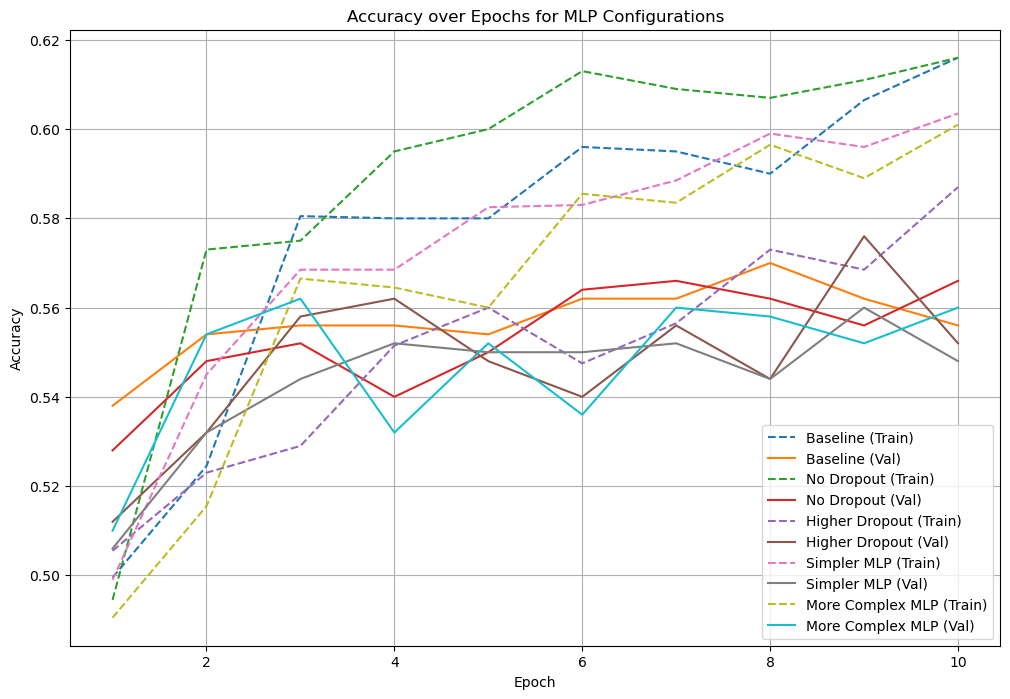

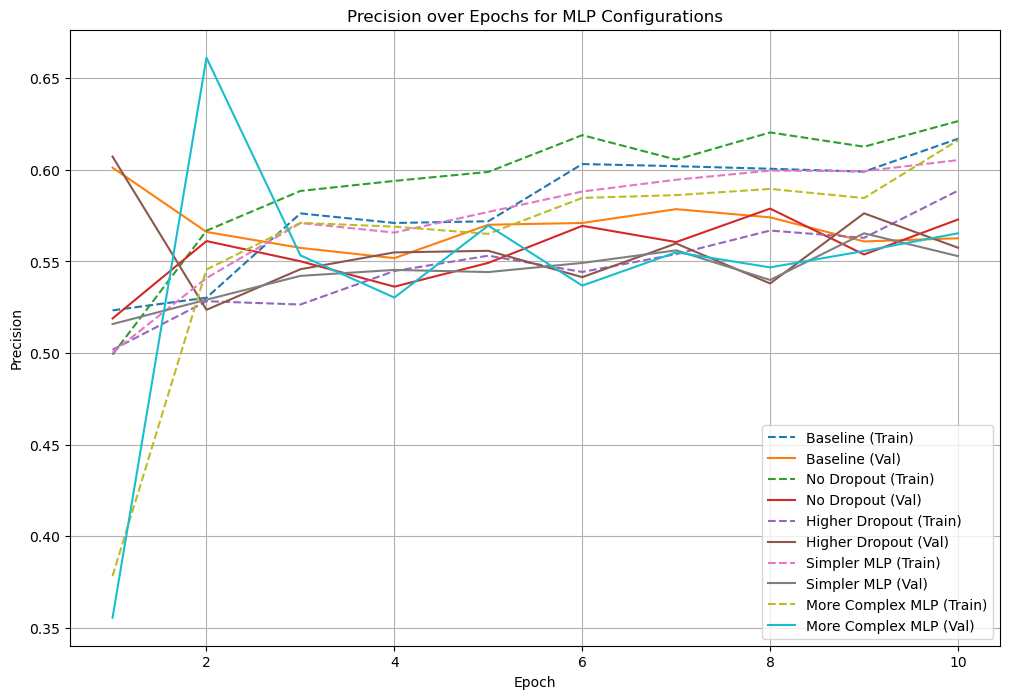

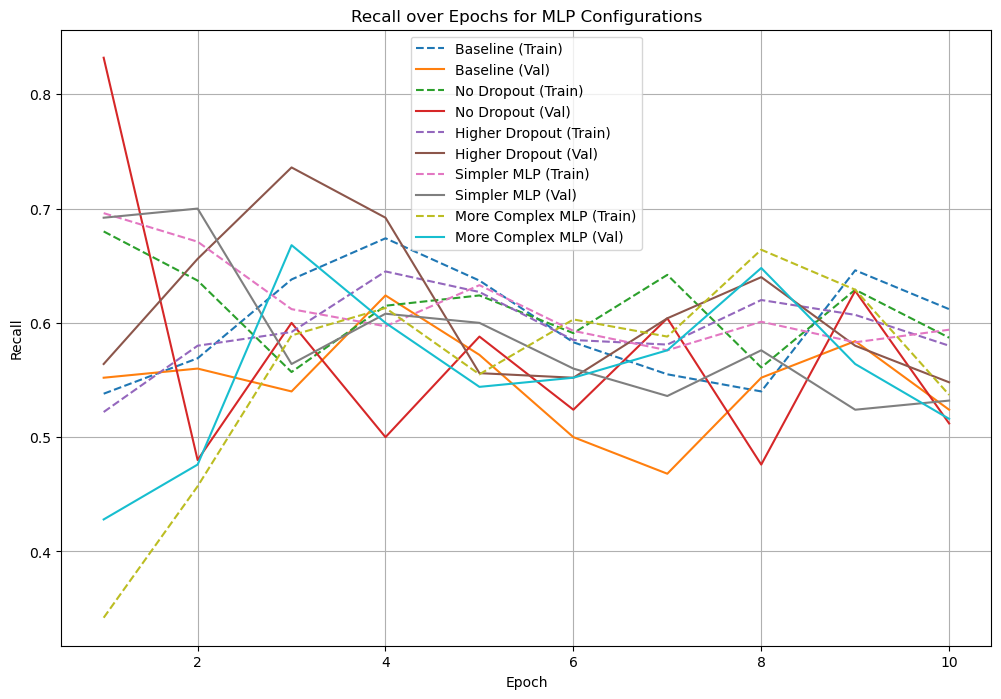

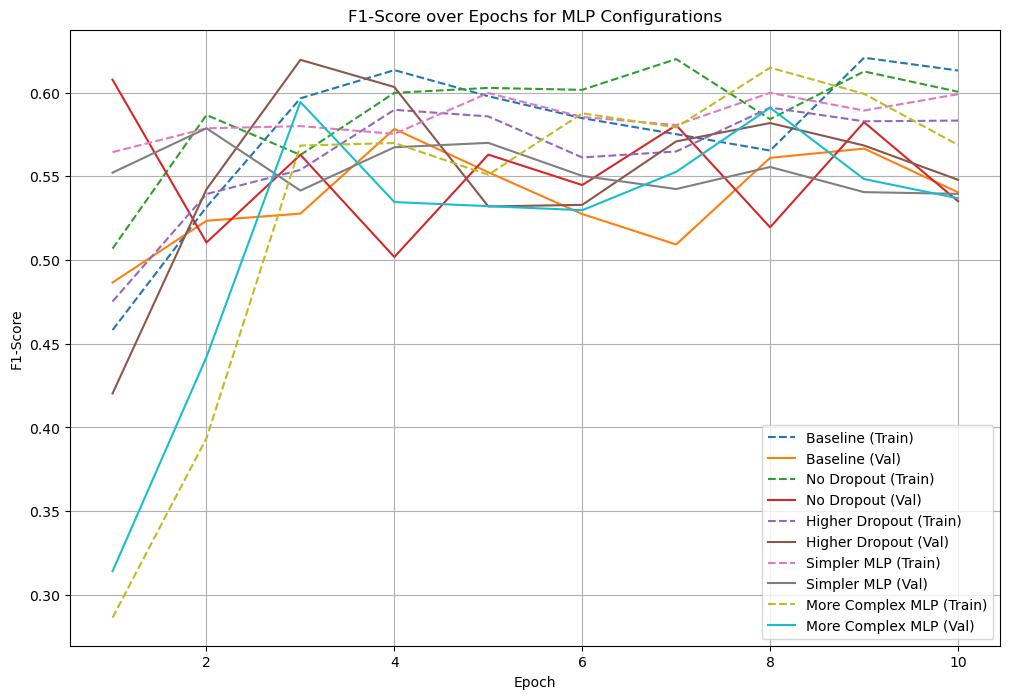

In [ ]:
# Learning Curves for MLP Configurations
metrics_to_plot = ['accuracies', 'precisions', 'recalls', 'f1s']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for metric, title in zip(metrics_to_plot, titles):
    plt.figure(figsize=(12, 8))
    for name, metrics in all_config_metrics.items():
        plt.plot(range(1, epochs+1), metrics[f'train_{metric}'], label=f"{name} (Train)", linestyle='--')
        plt.plot(range(1, epochs+1), metrics[f'eval_{metric}'], label=f"{name} (Val)")
    plt.xlabel("Epoch")
    plt.ylabel(title)
    plt.title(f"{title} over Epochs for MLP Configurations")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
mlp_metrics = {
    name: {
        'eval_accuracies': metrics['eval_accuracies'][-1],
        'eval_precisions': metrics['eval_precisions'][-1],
        'eval_recalls': metrics['eval_recalls'][-1],
        'eval_f1s': metrics['eval_f1s'][-1],
        'eval_auc': metrics['eval_auc'][-1]
    } for name, metrics in all_config_metrics.items()
}

## Scikit-Learn Models

In [ ]:
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

# Extract embeddings and labels (assuming data_set is available)
X = data_set.embeddings.numpy()
y = data_set.labels.numpy()

# Define scikit-learn models
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42)),
    "Gaussian Naive Bayes": make_pipeline(StandardScaler(), GaussianNB()),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

scikit_results = {}

# Evaluate models using custom_cross_validate
for name, model in models.items():
    print(f"\nEvaluating {name} with 5-fold CV...")
    scores = cross_validate(model, X, y, cv=5, scoring=scorers, return_train_score=True, n_jobs=-1)
    
    # Store mean training and validation metrics
    scikit_results[name] = {
        'train_accuracy': np.mean(scores['train_accuracy']),
        'train_precision': np.mean(scores['train_precision']),
        'train_recall': np.mean(scores['train_recall']),
        'train_f1': np.mean(scores['train_f1']),
        'train_roc_auc': np.mean(scores['train_roc_auc']),
        'eval_accuracy': np.mean(scores['test_accuracy']),
        'eval_precision': np.mean(scores['test_precision']),
        'eval_recall': np.mean(scores['test_recall']),
        'eval_f1': np.mean(scores['test_f1']),
        'eval_roc_auc': np.mean(scores['test_roc_auc'])
    }


Evaluating Logistic Regression with 5-fold CV...

Evaluating Gaussian Naive Bayes with 5-fold CV...

Evaluating Random Forest with 5-fold CV...

Evaluating Gradient Boosting with 5-fold CV...


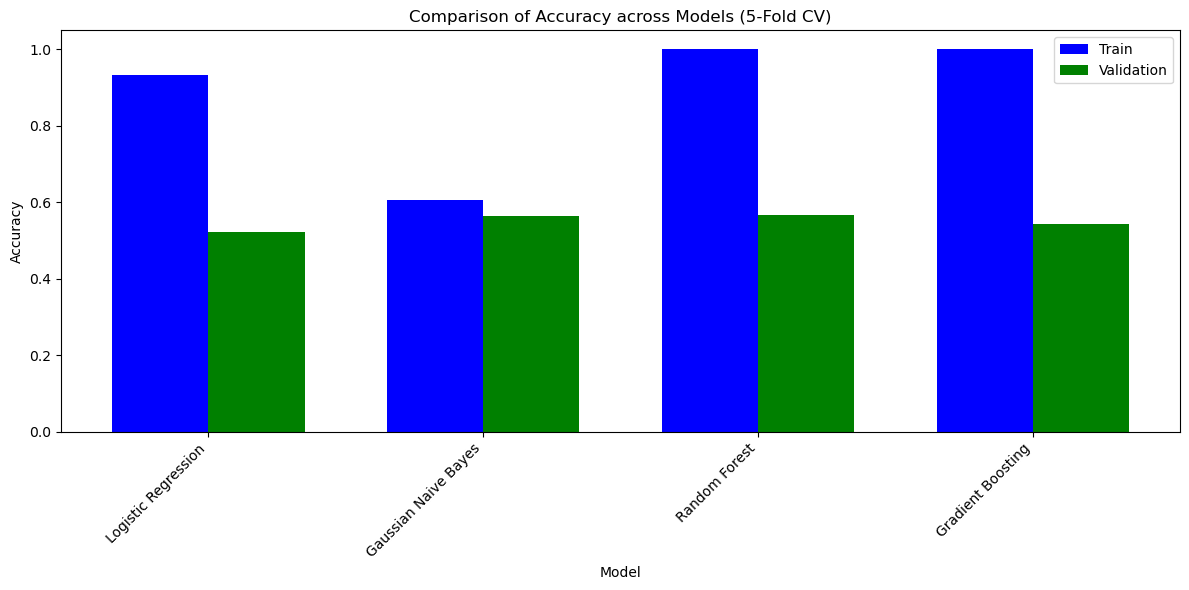

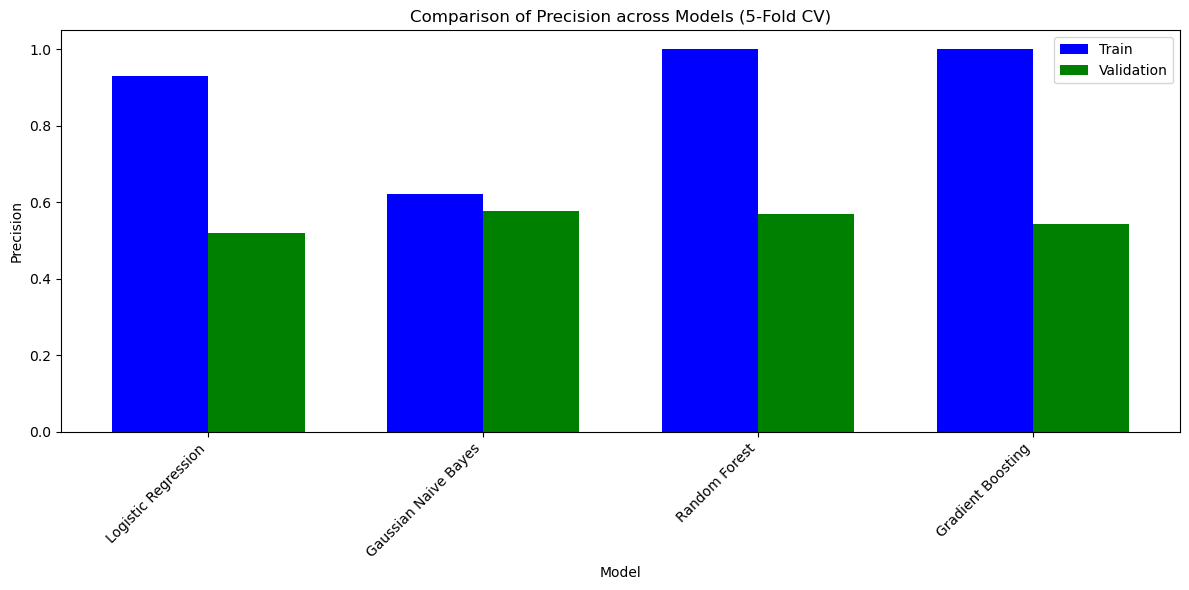

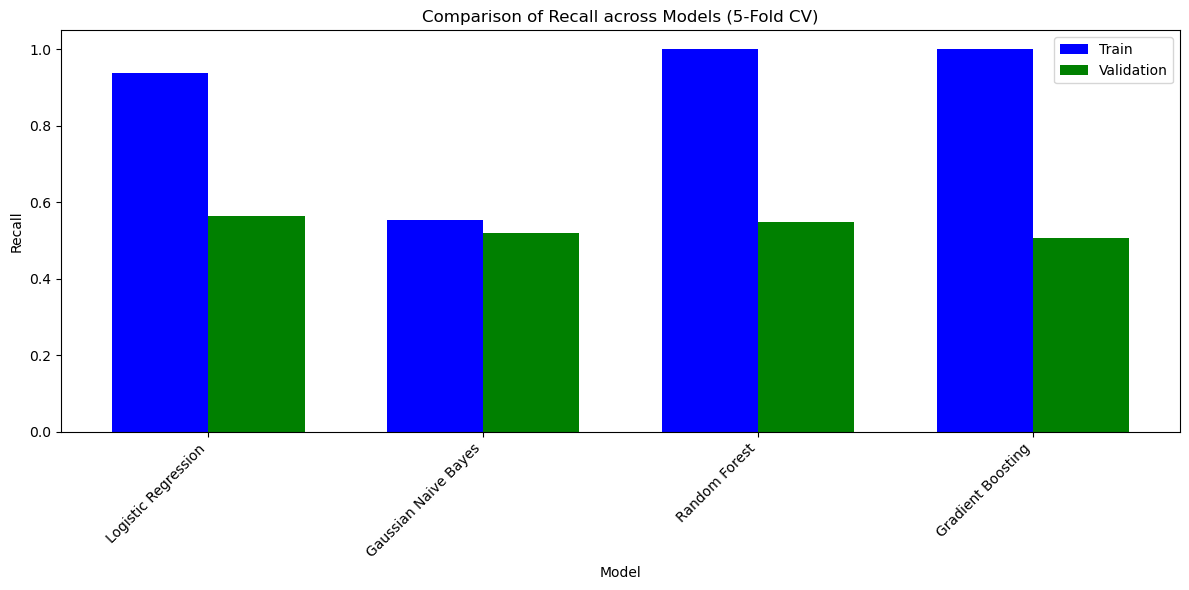

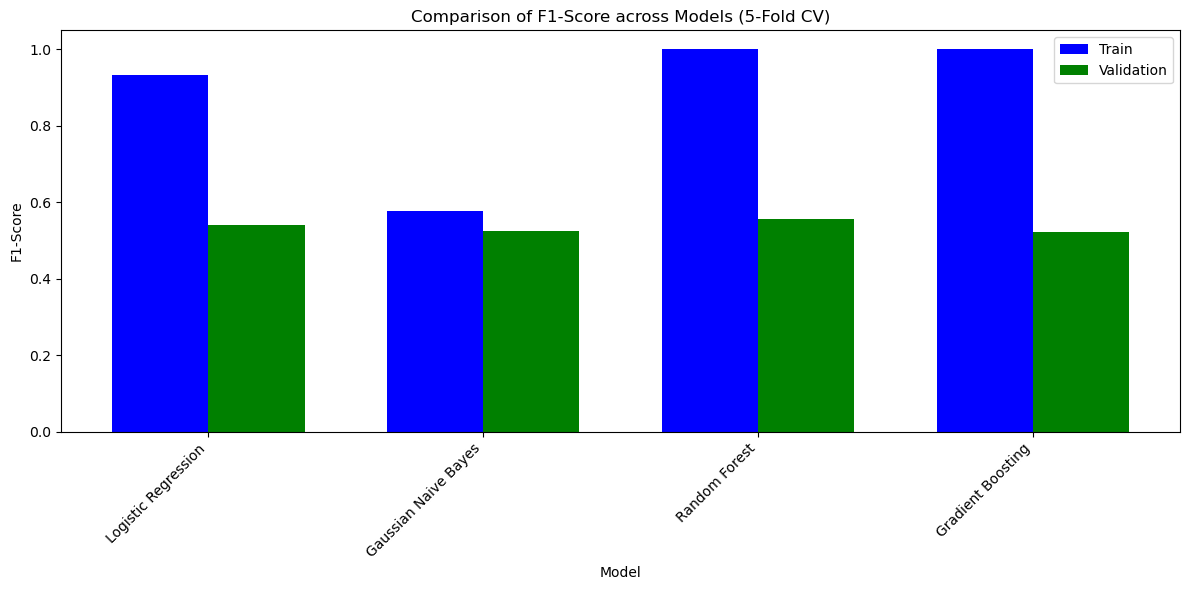

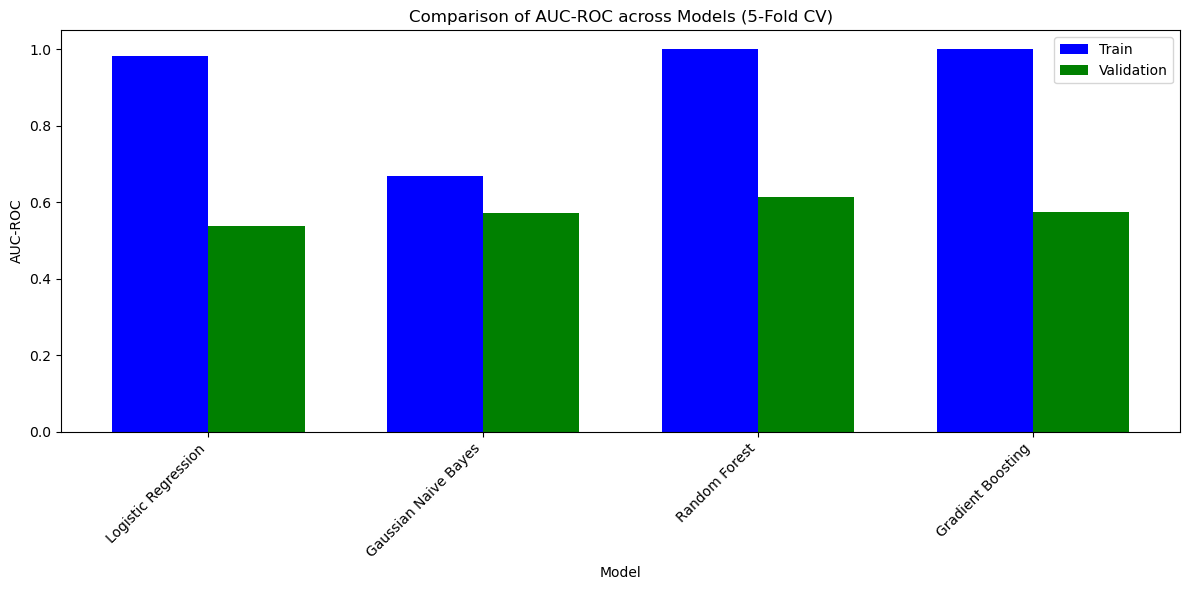

In [ ]:
# Visualization
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for metric, title in zip(metrics_to_plot, titles):
    plt.figure(figsize=(12, 6))
    train_values = [scikit_results[name][f'train_{metric}'] for name in models.keys()]
    eval_values = [scikit_results[name][f'eval_{metric}'] for name in models.keys()]
    model_names = list(models.keys())
    
    x = np.arange(len(model_names))
    width = 0.35
    plt.bar(x - width/2, train_values, width, label='Train', color='blue')
    plt.bar(x + width/2, eval_values, width, label='Validation', color='green')
    plt.xlabel("Model")
    plt.ylabel(title)
    plt.title(f"Comparison of {title} across Models (5-Fold CV)")
    plt.xticks(x, model_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()